---
>「ものごとの価値観、正邪の判断の基準がすぐれて相対的なものであるということは、いくら強調しておいてもよいだろう。
> 人間のなしうる最良の選択は、視野に映る多くの事象を比較対照して、よりまし、と思われるほうに身をおくことでしかない。」
>
> ヤン・ウェンリー
---

# 同時に2つの目標を達成するネットワーク

複数の関連するタスクを同時に学習する手法をマルチタスク学習と呼ぶ

では、同時に複数の目標を達成したい場合はどうすればよいだろうか

- 物体検出の例
  - 物体認識では、その画像にある物体を認識させるため、認識させたい物体のラベルに合致しているかどうかが問われるが、物体検出では、その画像にある物体のラベルと、その場所、実際にはその大きさなども検出する必要がある
  - このように場所の推定と、物体のラベルの推定を同時に行う必要がある
  - 実際には、複数の物体が存在している可能性があるため、それほど単純化できない
- 文章分類の例
  - 文章分類において、その文章のジャンルラベルの推定と、その文章がある事柄に関してポジティブな内容なのか、ネガティブな内容なのかを識別したいとすると、同様にこれら2つの推定を同時に行う必要がある

そのほか、今後学ぶネットワーク構造のGANなどもGeneratorとDiscriminatorの2つのネットワークを競争的に同時に学習させるように、複数の目的(タスク)を同時に達成するようなモデルを扱うことが多々ある

このようなモデルを構築・学習するにはどうすればよいであろうか

## シンプルに2つのモデルを構築する

これまで学んだ内容だけでも、対応は可能である

上記の例であれば、画像を入力とし、位置を表すベクトルと、物体のラベルを示すベクトルの両方を並べたベクトルを出力とすればよいであろう

ではこれらの複数のその時のロス関数はどのようにすればよいであろうか？

ナイーブには完全に別のネットワークを構築し個別に学習させることである

<img src='http://class.west.sd.keio.ac.jp/dataai/text/multi1.png' width=600>

この手法はこれまで学んだ手法と何ら変わらない

## 2つのモデルにかなりの共通点がある場合のモデル(融合型)

例えば図が物体検出の例を表しているとすると、出力$y_A$つまり物体のラベルについてはクロスエントロピーロス、出力$y_B$つまり物体の位置についてはMSEロスでよいといえ、これらを完全に別々に学習させればよい

この場合、同じ入力xを両方で利用しており、かつ、隠れ層の初期は画像の大局的な特徴をつかむように学習されるとすると、同じような学習を両方で行っているとも考えられ、無駄に思うであろう

では、これを解決するために、次のようなネットワークを構築したとする

<img src='http://class.west.sd.keio.ac.jp/dataai/text/multi2.png' width=600>

それぞれの目的について異なる2つのロス関数が現れることになるが、この場合どのようにして最適化すればよいであろうか

シンプルには、これら2つを足せばよい
- 両方のロス関数ともに正の値をとり、0に近づけることが目的であることから、足した値も0に近づけば両方のロス関数ともに0に近づく

このように、複数の目的を達成する場合、それらのロス関数をすべて足し合わせればよいであろう

ただし、**このような形は実際にはほとんど見ることがない**
- それぞれのロス関数に基づくウェイトの更新がネットワーク全体に波及するため、更新の方向が衝突しあってうまくいかないのではないかという懸念
  - 次の分岐などは、緩衝のための層があると考えることもできる
  - 目的が異なるから複数の目的設定しているので、これを体現するべき
  - 比較上結果が悪くなる傾向にある


## モデル間に共通点が見られるが目的が異なる場合(分岐型)

出力Aで表現したい目的と、出力Bで表現したい目的が異なる場合は、どこかで分岐し、分岐した後にそれぞれの目的にあったネットワークを構築したいと考えるであろう
  - この分岐以降のネットワークが緩衝材となって

<img src='http://class.west.sd.keio.ac.jp/dataai/text/multi3.png' width=600>

このような場合も同様に考えてよい

途中でネットワークが分岐することになるが、このような分岐は、得られたベクトルを1次元ベクトルとし、必要なところのみ切り出してそれぞれ独立したネットワークに入力すればよい
- 分岐そのものは難しくないであろう

さらに言えば、ある条件のときにある分岐のみ算出するといった場合も、それほど気にせずにネットワークと正伝搬を求めればよく、それぞれの目的によって必要な部分のパラメタを更新すればよい

正伝搬さえ計算できれば、その計算記録から逆伝搬を自動的に計算できる、これがDefine-by-Runの凄みである

## 既にあるネットワークの途中から分離してネットワークを追加する(分離追加型)

最後にもう一つ別のパターンを考える

- あるネットワークに対して、もう一つ別の目的を達成するためのネットワークを追加する場合について考えてみよう

<img src='http://class.west.sd.keio.ac.jp/dataai/text/multi4.png' width=600>


このケースでは何が違うのか問うと、ネットワークの記述において、完全に2つの別の記述が存在し、それぞれで最適化するのではなく、全体として最適化を行うという点である
- この場合は、一つの最適化関数に、両方の必要部分のパラメタを更新するように指定するとよい
- それぞれを最適化する場合は特に最適化関数の扱い方に工夫は必要ない(GANのジェネレータとディスクリミネータの場合など)


# 参考プログラム

以下、比較評価するが、乱数を固定して条件を揃える

In [ ]:
import random
import numpy as np
import torch

def torch_fix_seed(seed=24):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

もうひとつ、GPUについてもここで宣言しておく

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

各例について単体でも実行できるコードを示す
- 最初に基本となる数字認識のみ行う単一目的のMNIST
- 特に複雑なことはしていないがDataLoaderすら用いずに学習させている
  - numpyの配列の要素をランダムに並べ替えた新しい配列を生成する関数を用いてデータを並び替え
  - その先頭からバッチサイズ(bs=200)ごと切り出して学習、最後bs個取得できない場合は最後まで取得
  - これを10エポック行う

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y0 = dataset.targets

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(50 * 8 * 8, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        return self.fc(x)

model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y0)
bs = 200
losses = []
epochs = 5

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y = y0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        loss = criterion(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(j, loss.item())

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 351kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.97MB/s]


0 0.15692274272441864
1 0.05137712135910988
2 0.046510759741067886
3 0.12824326753616333
4 0.029423847794532776


ロスをグラフ化する

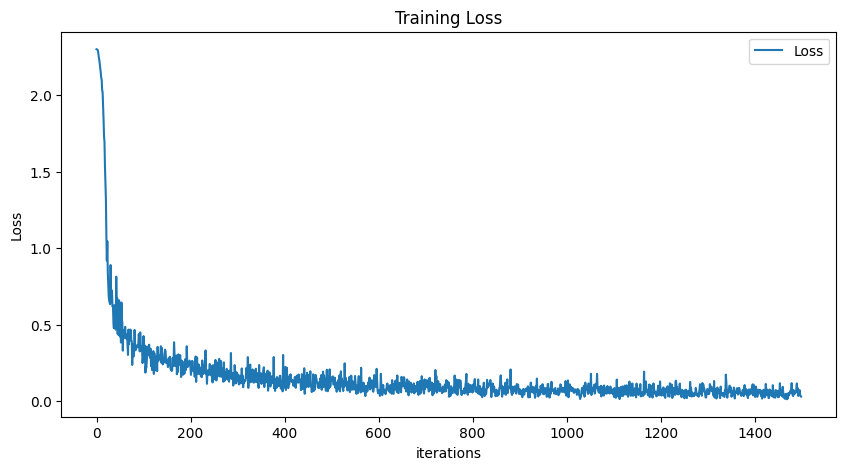

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証用データを用いて検証する

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xtest = tdataset.data.reshape(10000,1,28,28) / 255.0
ytest = tdataset.targets
model.eval()
with torch.no_grad():
    y1 = model(xtest.to(device))
    ans = torch.argmax(y1,1).to('cpu')
    print(((ytest == ans).sum().float()/len(ans)).item())

0.9825999736785889


## 融合型(ロス融合型)

2つの独立した簡単なタスクを想定する
- 一つは数字画像の識別でラベルは0から9である
  - 数字の識別はワンホット表現で10出力
- もう一つは数字画像に丸い部分があるかないかを識別し、0,6,8,9の数字のみTrue(1)、なければFalse(0)とする
  - 丸の識別はやはりワンホット表現で2出力

以上あわせて、12出力とする

ネットワークからの出力を単純に切り分けてそれぞれでロスを計算する

ここで、2つロスを計算するのに、criterionつまり、ロス関数は一つでよいのか？という疑問があるとすると、これは心配いらず一つでよい
- 計算するだけで、内部に何も値を保持していない
- クラスではなく純粋に関数である

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9, 0]):
        y02[i] = 1
    else:
        y02[i] = 0

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(3200, 12)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        x = self.fc(x)
        return x

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y01)
bs = 200
epochs = 5
losses = []
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        out1 = output[:,0:10]
        out2 = output[:,10:12]
        loss1 = criterion(out1, y1)
        loss2 = criterion(out2, y2)
        loss = loss1 + loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss.item())

0 0.17391788959503174
1 0.05851759761571884
2 0.0748508870601654
3 0.03768787533044815
4 0.043090879917144775


ロスをグラフにする
- 文字認識のロス(loss1)、丸認識のロス(loss2)、全体のロス(loss)を記載

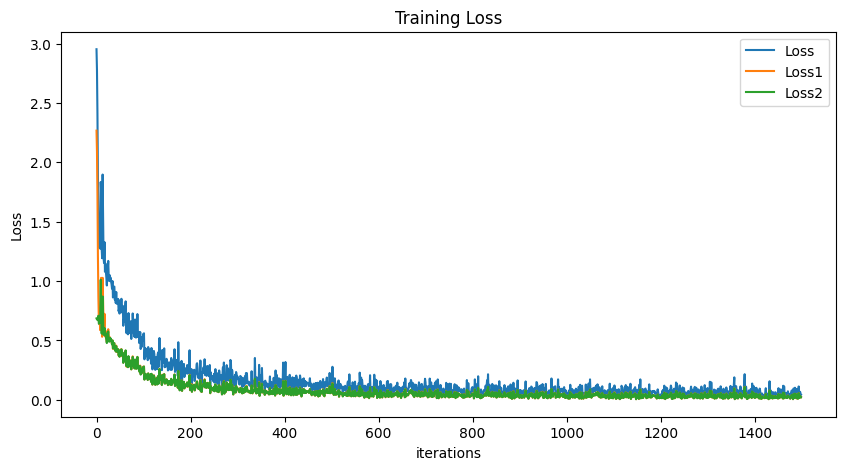

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証データを用いて、数字認識と丸認識それぞれの精度を求める

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model.eval()
with torch.no_grad():
    cnnx = model(xt.to(device))
    out1 = cnnx[:,0:10]
    out2 = cnnx[:,10:12]
    ans1 = torch.argmax(out1.to('cpu'), 1)
    ans2 = torch.argmax(out2.to('cpu'), 1)
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.8927000164985657
0.8927000164985657


## 融合型(多重更新型)

先ほどと似ているが、`loss = loss1+loss2`とせず、`loss1`と`loss2`それぞれで逆伝搬を求める

この場合、ネットワークは2回逆伝搬で更新されることになるため、通常では`RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. `といったエラーが出力される

これを回避するため、backwordメソッドを呼び出す際に`retain_graph=True`としてエラーにならないようにしている

パラメータは、各lossを求める際に、それぞれの値で更新されることになる

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(3200, 12)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        x = self.fc(x)
        return x

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y01)
bs = 200
epochs = 5
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        out1 = output[:,0:10]
        out2 = output[:,10:12]
        loss1 = criterion(out1, y1)
        loss2 = criterion(out2, y2)
        optimizer.zero_grad()
        loss1.backward(retain_graph=True)
        loss2.backward()
        optimizer.step()
        losses.append(loss.item())
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss1.item(), loss2.item())

0 0.07956515997648239 0.07918338477611542
1 0.032339394092559814 0.031730324029922485
2 0.05126551538705826 0.05223996937274933
3 0.058100394904613495 0.058972083032131195
4 0.028911598026752472 0.02865803986787796


この場合、先ほどの例と比較すると、回数で2倍多く更新を行っているので、条件が合えばより早く収束することになる

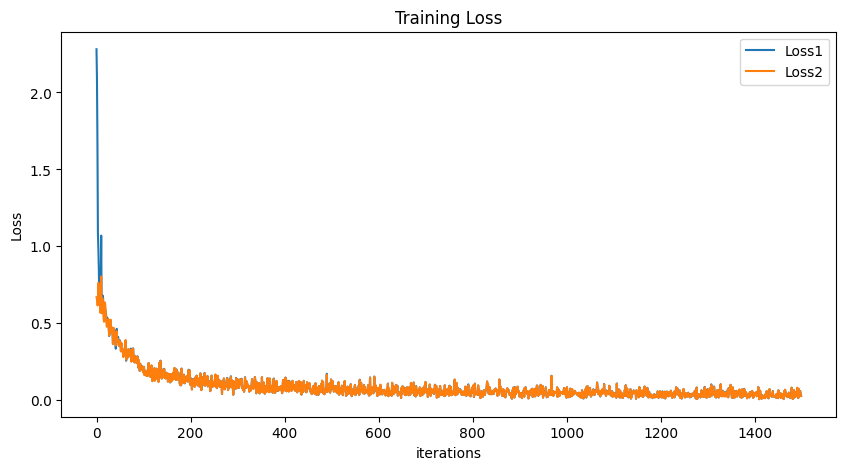

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証データを用いて、数字認識と丸認識それぞれの精度を求める

2つを同時に行うため、2つは揃って精度を高めあうことになる
- 従って、先の例の中間的な精度になると予想できる

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model.eval()
with torch.no_grad():
    cnnx = model(xt.to(device))
    out1 = cnnx[:,0:10]
    out2 = cnnx[:,10:12]
    ans1 = torch.argmax(out1.to('cpu'), 1)
    ans2 = torch.argmax(out2.to('cpu'), 1)
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9872000217437744
0.9871000051498413


## 分岐型

分岐させるために、分岐後それぞれのタスクを担当するfc1、fc2を定義する
- モデルではfc1、fc2を定義しているが、モデル内では利用していない
- `output = model(x)`を求めた後、`out1 = model.fc1(output)`および、`out2 = model.fc2(output)`としてそれぞれ求める

この場合でも、fc1を利用する数字識別タスクのforwardと、fc2を利用する丸識別タスクのforwardそれぞれについて損失を算出し、最適化関数を呼び出せばよい
- ただし、backwordは一度でまとめて呼び出すため、`loss`を`loss1+loss2`として加算してたのち、backwordを求める

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(3200, 10)
        self.fc2 = nn.Linear(3200, 2)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1)
        return x

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y01)
bs = 200
epochs = 5
losses = []
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        out1 = model.fc1(output)
        out2 = model.fc2(output)
        loss1 = criterion(out1,y1)
        loss2 = criterion(out2,y2)
        loss = loss1 + loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss.item())

0 0.19121628999710083
1 0.07606464624404907
2 0.10974705219268799
3 0.11842446029186249
4 0.06234341114759445


ロス曲線を描画する

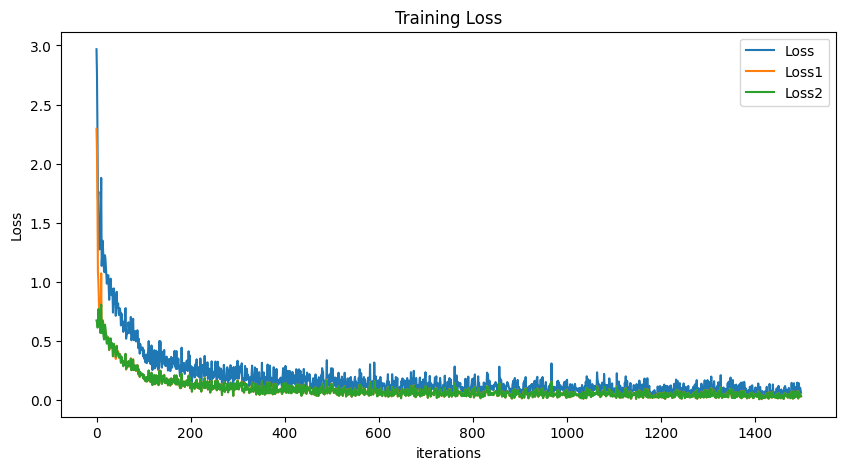

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証データで精度を求める

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model.eval()
with torch.no_grad():
    cnnx = model(xt.to(device))
    out1 = model.fc1(cnnx.to(device))
    out2 = model.fc2(cnnx.to(device))
    ans1 = torch.argmax(out1.to('cpu'), 1)
    ans2 = torch.argmax(out2.to('cpu'), 1)
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9882000088691711
0.9879000186920166


なお、融合型と分岐型のどちらが精度がよくなるかは扱うタスクに依存し、慎重に検討、適切に選択する必要がある
- 今回の場合、結果は各自で異なると思われるが、ほぼ同じ、どちらがよくなるかは乱数に依存するであろう

特に、個別に設けたネットワークの独自性が十分に発揮できるかどうかの議論が必要である

- 分離型にすることで、片方だけリッチなネットワークを提供できるため、問題の複雑度合いに対応することができるであろう
- 相互でノードの数が等しい場合は、融合型の方が結果的に最終層のノード間接続数が多くなり、能力が高くなる可能性がある
  - つまり、分離するならば、複雑度合いを変えるべき問題を扱い、そのようなネットワークを構築するべきである



## 分岐型(多重更新型)

先ほどの多重更新型と同様、`loss = loss1+loss2`とせず、`loss1`と`loss2`それぞれで逆伝搬を求める

同様に、backwordメソッドを呼び出す際に`retain_graph=True`としてエラーにならないようにしている

パラメータは、各lossを求める際に、それぞれの値で更新されることになる

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(3200, 10)
        self.fc2 = nn.Linear(3200, 2)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1)
        return x

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y01)
bs = 200
epochs = 5
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        out1 = model.fc1(output)
        out2 = model.fc2(output)
        loss1 = criterion(out1,y1)
        loss2 = criterion(out2,y2)
        optimizer.zero_grad()
        loss1.backward(retain_graph=True)
        loss2.backward()
        optimizer.step()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss1.item(), loss2.item())

0 0.09879979491233826 0.09529371559619904
1 0.03782659024000168 0.03718194365501404
2 0.0544157400727272 0.054577313363552094
3 0.06094304099678993 0.060190632939338684
4 0.03141456097364426 0.03189196065068245


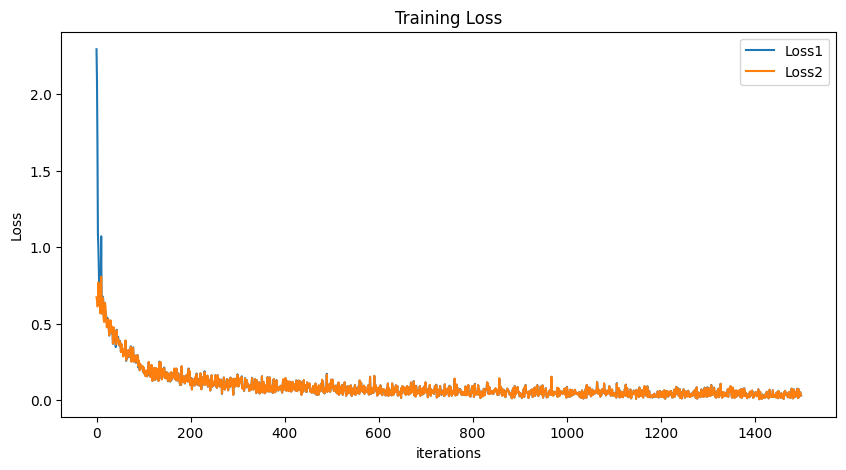

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証データを用いて、数字認識と丸認識それぞれの精度を求める
- 先ほどよりもネットワーク前段の学習回数が多くなるため、過学習にならなければ、若干改善することが予測される

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model.eval()
with torch.no_grad():
    cnnx = model(xt.to(device))
    out1 = model.fc1(cnnx.to(device))
    out2 = model.fc2(cnnx.to(device))
    ans1 = torch.argmax(out1.to('cpu'), 1)
    ans2 = torch.argmax(out2.to('cpu'), 1)
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9879999756813049
0.988099992275238


## 分離追加型

すでに存在するネットワーク(CNN1)があり、それをそのまま無改変で利用したい(コードを改変したくない)場合は、分岐のためのネットワーク改変が直接的にできない
- そこで、新たなネットワーク(CNN2)を構築し、分岐させていたところから同様にCNN2へとつなげる
- 結果的に分岐型と同じであるが、実現のさせ方が異なる

分離して追加する方法
- 独自のネットワーク(ここではCNN2)を定義する
- CNN1のネットワークの途中ノードからリンク(重みを掛けて次のノードに伝える線)を取り出すため、どうしてもforwardに手を入れる必要がある
  - CNN1のクラス定義に手を入れずに、その途中からデータを取り出すため、別途forward(ここではfwd関数)を定義する
  - このforwardにおけるノードの呼び出し方について、既に宣言済みのネットワークのノードを参照するため独特となる
  - クラスの中で定義する必要はない
- 別途forwardを定義したため、学習や検証ではこのforwardを呼び出す
- 分岐した後、追加側のネットワークと、元のネットワークの残りの部分の計算を行う
  - ここでは元のネットワークの残りの部分が1層のみであるため直接呼び出しているが、この部分が大きい場合は、新たなfwd関数を準備して処理するとよい
  - つまり、今回は、CNN1をfwdとfcに分割しているが、CNN1をfwd1とfwd2に分割して処理するようにするとよい

この場合、最も困難なのは最適化をどのように行うかである

```
optimizer = optim.SGD([
    {'params': model1.parameters()},
    {'params': model2.parameters()}
], lr=0.01, momentum=0.9)
```

PyTorchの最適化関数について、その第1引数は、torch.Tensorのiterableもしくは、dict型で指定する必要がある
- 通常は、model.parameters()とするが、このmode.parameters()を実際に見るとわかる通り、各層のネットワークのパラメタが全て含まれたdict型の変数であることがわかる
  - これについては、後で確認してみよう
- モデルが複数ある場合、dict型で束ねれば、全体について記述するとよい
  - ここでは、CNN1とCNN2があるため、両方指定する必要がある
- 別途記述したfwdは、とにかく計算してあげれば、AutoGradにより全計算手順がtorch.tensorの型の中で保存されるため、特に何もケアする必要はない
  - つまり、パラメタだけ渡せば、どのような途中計算をクラス外で行おうとも、パラメタ更新を行うことができる
  - これも、Define-by-Runの特徴

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(3200, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1)
        return self.fc(x)

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.fc = nn.Linear(3200, 2)
    def forward(self, x):
        return self.fc(x)

model1 = CNN1().to(device)
model2 = CNN2().to(device)
optimizer = optim.SGD([
    {'params': model1.parameters()},
    {'params': model2.parameters()}
], lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def fwd(model, x):
    x = F.relu(model.cn1(x))
    x = model.pool1(x)
    x = F.relu(model.cn2(x))
    x = x.view(len(x), -1)
    return x

n = len(y01)
bs = 200
epochs = 5
losses = []
losses1 = []
losses2 = []

model1.train()
model2.train()

for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = fwd(model1, x)
        out1 = model1.fc(output)
        out2 = model2(output)
        loss1 = criterion(out1,y1)
        loss2 = criterion(out2,y2)
        loss = loss1 + loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss.item())

0 0.19121628999710083
1 0.07606464624404907
2 0.10974705219268799
3 0.11842446029186249
4 0.06234341114759445


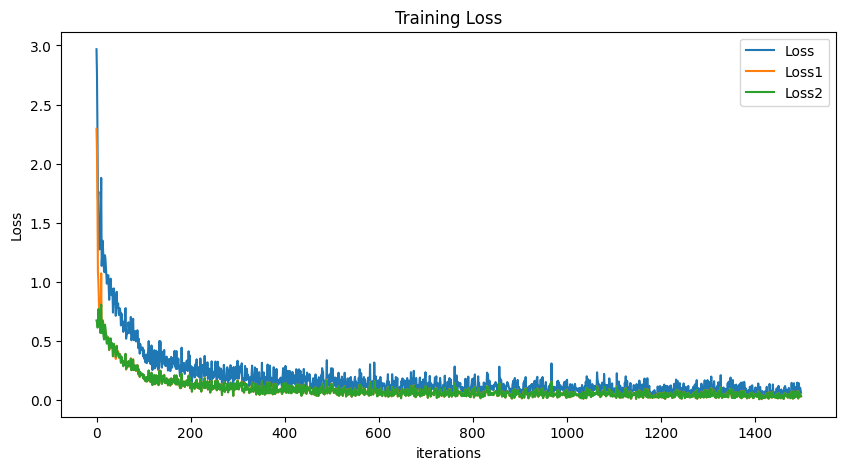

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model1.eval()
model2.eval()
with torch.no_grad():
    cnnx = fwd(model1, xt.to(device))
    out1 = model1.fc(cnnx)
    out2 = model2(cnnx)
    ans1 = torch.argmax(out1,1).to('cpu')
    ans2 = torch.argmax(out2,1).to('cpu')
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9882000088691711
0.9879000186920166


本質的に、何も変わらないはずで、結果つまり精度も分離型とほぼ同じになる

## 結果再利用型

まず、普通にMNISTの手書き数字認識を行った後、その結果をもう一つのタスク、丸を含むかどうかを求めるネットワークに入力して学習させる
- これが上手くいくのは、最初の予測結果がそのまま、次の予測結果に使えることがわかっている時のみ
- 今回は、数字認識ができれば、丸の有り無しも当然予測できるはずであるためうまくいく

このとき、丸を含むかどうかを求めるネットワークの学習時に、手前の手書き数字認識を求めるネットワークを更新しないようにparmを設定している

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(50 * 8 * 8, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        return self.fc(x)

class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model1 = CNN().to(device)
model2 = FC().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y0)
bs = 200
epochs = 5
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        for param in model1.parameters():
            param.requires_grad = True
        output = model1(x)
        loss1 = criterion(output,y1)
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        for param in model1.parameters():
            param.requires_grad = False
        input2 = output.detach().clone()
        output = model2(input2)
        loss2 = criterion(output,y2)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss1.item(), loss2.item())

0 0.12018846720457077 0.12788385152816772
1 0.036716338247060776 0.032456472516059875
2 0.07508671283721924 0.07917650043964386
3 0.07002420723438263 0.0758214071393013
4 0.04217264801263809 0.04215271398425102


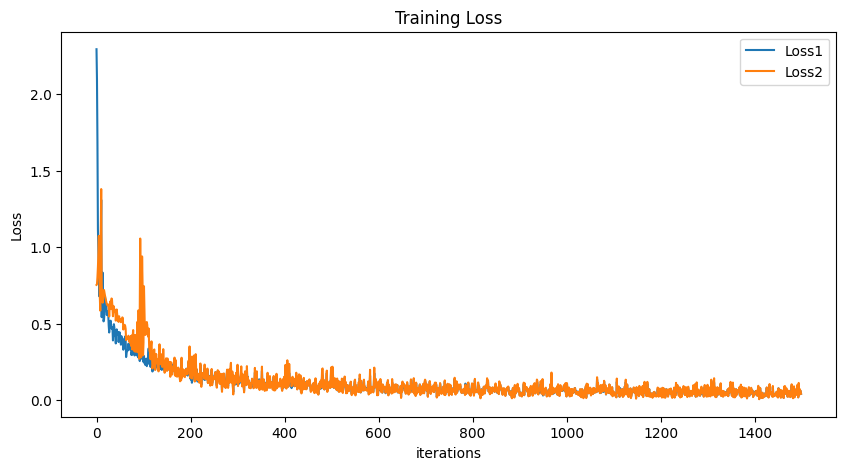

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model1.eval()
model2.eval()
with torch.no_grad():
    out1 = model1(xt.to(device))
    out2 = model2(out1)
    ans1 = torch.argmax(out1,1).to('cpu')
    ans2 = torch.argmax(out2,1).to('cpu')
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9848999977111816
0.9848999977111816


## 結果再利用型(多重更新型)

先の例を多重更新に変更する

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(50 * 8 * 8, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        return self.fc(x)

class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model1 = CNN().to(device)
model2 = FC().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y0)
bs = 200
epochs = 5
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model1(x)
        loss1 = criterion(output,y1)
        optimizer1.zero_grad()
        loss1.backward(retain_graph=True)
        optimizer1.step()
        input2 = output.detach().clone()
        output = model2(input2)
        loss2 = criterion(output,y2)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss1.item(), loss2.item())

0 0.12018846720457077 0.12788385152816772
1 0.036716338247060776 0.032456472516059875
2 0.07508671283721924 0.07917650043964386
3 0.07002420723438263 0.0758214071393013
4 0.04217264801263809 0.04215271398425102


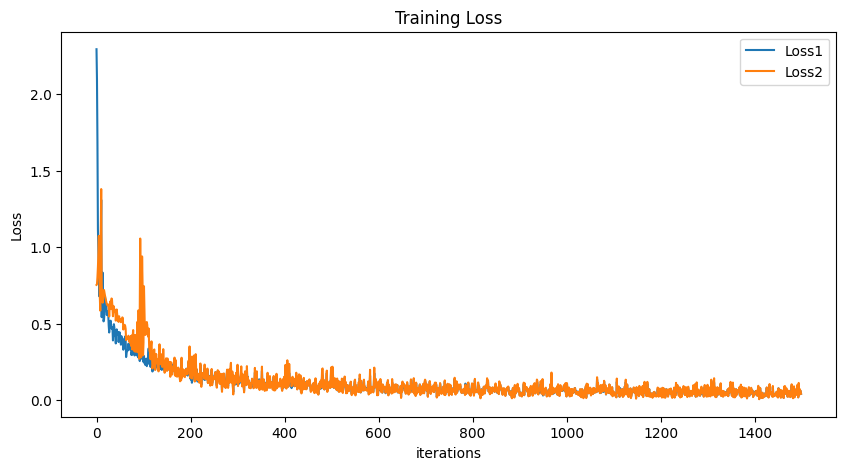

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model1.eval()
model2.eval()
with torch.no_grad():
    out1 = model1(xt.to(device))
    out2 = model2(out1)
    ans1 = torch.argmax(out1,1).to('cpu')
    ans2 = torch.argmax(out2,1).to('cpu')
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9848999977111816
0.9848999977111816


## もう一つの例: 偶数/奇数情報の除去

別の簡単な例として、数字を分類しつつ、その数字が偶数か奇数かという情報を予測できないようにする例を示す

In [ ]:
# 偶数/奇数ラベルを生成
y_parity = (y_digit % 2).astype(np.int64)  # 0: 偶数, 1: 奇数

# データ分割
y_parity_train = y_parity[:n_train]
y_parity_test = y_parity[n_train:]

print(f"偶数/奇数ラベルの生成完了")
print(f"例: 数字=2 → 偶数(0), 数字=3 → 奇数(1)")

偶数/奇数ラベルの生成完了
例: 数字=2 → 偶数(0), 数字=3 → 奇数(1)


### 偶数/奇数除去モデルの定義

In [ ]:
class ParityRemovalCNN(nn.Module):
    """
    偶数/奇数情報を除去するモデル
    """
    def __init__(self, lambda_grl=1.0):
        super(ParityRemovalCNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 20, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 50, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 数字分類器
        self.digit_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

        # GRL
        self.grl = GradientReversalLayer(lambda_=lambda_grl)

        # 偶数/奇数分類器
        self.parity_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)

        digit_output = self.digit_classifier(features)

        reversed_features = self.grl(features)
        parity_output = self.parity_classifier(reversed_features)

        return digit_output, parity_output

print("偶数/奇数除去モデル定義完了")

偶数/奇数除去モデル定義完了


### 偶数/奇数除去モデルの学習

In [ ]:
print("=" * 50)
print("偶数/奇数情報除去モデルの学習")
print("=" * 50)

# 元のグレースケール画像を使用
x_gray_train = x_original[:n_train].reshape(-1, 1, 28, 28) / 255.0
x_gray_test = x_original[n_train:].reshape(-1, 1, 28, 28) / 255.0

torch_fix_seed(42)
model_parity = ParityRemovalCNN(lambda_grl=1.0)
history_parity = train_model(
    model_parity, x_gray_train, y_digit_train, y_parity_train,
    epochs=10, batch_size=200, lr=0.001
)

# 評価
digit_acc_parity, parity_acc = evaluate_model(
    model_parity, x_gray_test, y_digit_test, y_parity_test
)
print(f"\n【テスト結果】")
print(f"数字分類精度: {digit_acc_parity*100:.2f}%")
print(f"偶数/奇数分類精度: {parity_acc*100:.2f}% (50%に近いほど良い)")
print(f"\n※ 偶数/奇数分類精度が50%に近い = モデルが偶数/奇数を区別できない = 望ましい結果")

偶数/奇数情報除去モデルの学習
Epoch 1/10 - Digit Loss: 0.3925, Color Loss: 0.2187
Epoch 2/10 - Digit Loss: 0.1502, Color Loss: 0.2279
Epoch 3/10 - Digit Loss: 0.1540, Color Loss: 0.2236
Epoch 4/10 - Digit Loss: 0.1890, Color Loss: 0.3258
Epoch 5/10 - Digit Loss: 0.2030, Color Loss: 0.3861
Epoch 6/10 - Digit Loss: 0.2551, Color Loss: 0.4991
Epoch 7/10 - Digit Loss: 0.2196, Color Loss: 0.3982
Epoch 8/10 - Digit Loss: 0.2221, Color Loss: 0.4218
Epoch 9/10 - Digit Loss: 0.2026, Color Loss: 0.5648
Epoch 10/10 - Digit Loss: 0.1725, Color Loss: 0.5485

【テスト結果】
数字分類精度: 94.52%
偶数/奇数分類精度: 74.79% (50%に近いほど良い)

※ 偶数/奇数分類精度が50%に近い = モデルが偶数/奇数を区別できない = 望ましい結果


# (コラム) detach()とcloneについて

ここで、`detach().clone()`としてmodel2のネットワークを構築しているが、この順番は答えを得る上ではどうでもよい

しかしながら、実際には`clone().detach()`とすると異なる自動微分の計算グラフが構成される

既に述べているが、ここでdetachとcloneについて、より詳しく理解しよう

## detach()

detach()メソッドは、同一デバイス上に新しいtorch.tensorを作成し、元の自動微分の計算グラフから切り離されるが、値は共有している
- 結果的にrequireds_grad=Falseとなる
- コピー先を変更するとコピー元も変更される

In [ ]:
DEVICE = torch.device("cuda")
x = torch.tensor([2.0], device=DEVICE, requires_grad=False)
w = torch.tensor([1.0], device=DEVICE, requires_grad=True)
b = torch.tensor([3.0], device=DEVICE, requires_grad=True)
y = x*w+b
y.backward()
print("x:", x, x.grad, x.requires_grad, "\nw:", w, w.grad, w.requires_grad,
      "\nb:", b, b.grad, b.requires_grad, "\ny:", y, y.grad, y.requires_grad)

x: 

/tmp/ipython-input-2663654173.py:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  "\nb:", b, b.grad, b.requires_grad, "\ny:", y, y.grad, y.requires_grad)


tensor([2.], device='cuda:0') None False 
w: tensor([1.], device='cuda:0', requires_grad=True) tensor([2.], device='cuda:0') True 
b: tensor([3.], device='cuda:0', requires_grad=True) tensor([1.], device='cuda:0') True 
y: tensor([5.], device='cuda:0', grad_fn=<AddBackward0>) None True


これに対して、wに対してdetach()を呼び出すと次のようになる
- detachされたので、requireds_gradはFalseになるが、同じメモリ空間を指しており、配列の中身は共有している

In [ ]:
z = w.detach()
print("z:", z, z.grad, z.requires_grad)
print(z is w)

z: tensor([1.], device='cuda:0') None False
False


同じメモリ領域を共有しているため、zの[0]を変更するとwも変更される

In [ ]:
print(w, z)
z[0] = 2
print(w, z)

tensor([1.], device='cuda:0', requires_grad=True) tensor([1.], device='cuda:0')
tensor([2.], device='cuda:0', requires_grad=True) tensor([2.], device='cuda:0')


ちなみに、`w[0] = 2`とすると、`RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.`と表示されエラーとなる

従って、ここでは、無理やりrequires_gradをFalseにしてあげることで、wを変更してもzが変更されることが確認できる

In [ ]:
w.requires_grad_(False)

tensor([2.], device='cuda:0')

In [ ]:
w[0] = 3
print(w, z)

tensor([3.], device='cuda:0') tensor([3.], device='cuda:0')


さらに、zは単独で計算グラフの先頭(端)にあるため、is_leafでもTrueとなる

In [ ]:
z.is_leaf

True

この場合の計算グラフはdetachの前後で次のように変化する

<img src='http://class.west.sd.keio.ac.jp/dataai/text/dc-detach.png' width=800>



## clone

.clone() は同一デバイス上に新しいテンソルを作成し、clone元のテンソルに対して、自動微分の計算グラフが継続して構築される
- cloneでは、異なるメモリ空間を指すためisではFalseとなり、端でもない
- requires_gradはTrueとなる

In [ ]:
x = torch.tensor([2.0], device=DEVICE, requires_grad=False)
w = torch.tensor([1.0], device=DEVICE, requires_grad=True)
b = torch.tensor([3.0], device=DEVICE, requires_grad=True)
v = w.clone()
y = x*v + b
y.backward()
print("x:", x, x.grad, x.requires_grad, "\nw:", w, w.grad, w.requires_grad, "\nv:", v, v.grad, v.requires_grad,
      "\nb:", b, b.grad, b.requires_grad, "\ny:", y, y.grad, y.requires_grad)
print(v is w)
print(v.is_leaf)
print(v.requires_grad)

x: tensor([2.], device='cuda:0') None False 
w: tensor([1.], device='cuda:0', requires_grad=True) tensor([2.], device='cuda:0') True 
v: tensor([1.], device='cuda:0', grad_fn=<CloneBackward0>) None True 
b: tensor([3.], device='cuda:0', requires_grad=True) tensor([1.], device='cuda:0') True 
y: tensor([5.], device='cuda:0', grad_fn=<AddBackward0>) None True
False
False
True


/tmp/ipython-input-4255846331.py:7: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print("x:", x, x.grad, x.requires_grad, "\nw:", w, w.grad, w.requires_grad, "\nv:", v, v.grad, v.requires_grad,
/tmp/ipython-input-4255846331.py:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tenso

さて、この場合の計算グラフであるが、実際にはwのcloneであるvがxとの掛け算に繋がり、wとvの間に何も計算はない
- 実際、CLoneBackword0と記述され、計算ではない
- そこで、無理やりであるがcloneという演算があるとして表記する
ここで、$y = x \times v + b$をグラフで表記し、vのcloneであるwを1との掛け算で表すと次のようになる

<img src='http://class.west.sd.keio.ac.jp/dataai/text/dc-clone.png' width=500>


## GPUとCPUをまたぐ場合



.cpu()はcpu上のメモリにテンソルを生成するため、gpuにあるyとは違うメモリを参照するため、独立する

しかしながら、自動微分の計算グラフはつながるため、逆伝搬は可能である

In [ ]:
x = torch.tensor([2.0], device=DEVICE, requires_grad=False)
w = torch.tensor([1.0], device=DEVICE, requires_grad=True)
b = torch.tensor([3.0], device=DEVICE, requires_grad=True)
y = x*w + b
z = y.cpu()
v = torch.tensor([7.0], device="cpu", requires_grad=True)
c = torch.tensor([4.0], device="cpu", requires_grad=True)
f = v*z + c
f.backward()

In [ ]:
print(x)
print(w)
print(b)
print(y)
print(z)
print(v)
print(c)
print(f)

tensor([2.], device='cuda:0')
tensor([1.], device='cuda:0', requires_grad=True)
tensor([3.], device='cuda:0', requires_grad=True)
tensor([5.], device='cuda:0', grad_fn=<AddBackward0>)
tensor([5.], grad_fn=<ToCopyBackward0>)
tensor([7.], requires_grad=True)
tensor([4.], requires_grad=True)
tensor([39.], grad_fn=<AddBackward0>)


In [ ]:
print(x.grad)
print(w.grad)
print(b.grad)
print(y.grad)
print(z.grad)
print(v.grad)
print(c.grad)
print(f.grad)

None
tensor([14.], device='cuda:0')
tensor([7.], device='cuda:0')
None
None
tensor([5.])
tensor([1.])
None


/tmp/ipython-input-106651898.py:4: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print(y.grad)
/tmp/ipython-input-106651898.py:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/3053

In [ ]:
print(z.is_leaf)
print(v.is_leaf)
print(c.is_leaf)
print(f.is_leaf)
print(z.requires_grad)
print(v.requires_grad)
print(c.requires_grad)
print(f.requires_grad)

False
True
True
False
True
True
True
True


この場合の計算グラフは次のようになる

<img src='http://class.west.sd.keio.ac.jp/dataai/text/dc-gpucpu.png' width=600>

ここまでを踏まえると次のことがわかるであろう

detach().clone()

- .detach()して得られるテンソルは計算グラフから切り離されたテンソルであり、これを.clone()するため、メモリの参照場所も異なる独立した値となる
- 値として独立したテンソルであり逆伝播しない

clone().detach()

- .clone()して得られるテンソルは異なるメモリを参照しているが、計算グラフは繋がっている
- これを.detach()するため、計算グラフから切り離される

つまり、ここではこれらは動作上意味となるが、実際には計算グラフは異なる
```
b = a.detach()
c = b.clone()
```
と
```
b = a.clone()
c = b.detach()
```
の計算グラフは次のようになる
<img src='http://class.west.sd.keio.ac.jp/dataai/text/dc-dc.png' width=600>

## テンソルをコピーする場合、どうするのがよいのか？
1. y = tensor.new_tensor(x)
1. y = x.clone().detach()
1. y = torch.empty_like(x).copy_(x)
1. y = torch.tensor(x)
1. y = x.detach().clone() (推奨)

これらはすべて、コピーという意味では正しく動作するが、実行速度に差が出る

ここで、
1. y = tensor.new_tensor(x)
1. y = x.clone().detach()
この2つは公式ドキュメントにおいても同一であると説明されている

つまり、この2つは実行速度が瓜二つとなる、そしてそれは、他の3つよりも遅い点に注意する

他の3つは、ほぼ同じ実行速度であり、残り2つのおよそ60%から70%程度の実行遅延となる

従って、clone().detach()よりも、detach().clone()の方が低遅延で実行できることがわかる

# 勾配反転層

勾配反転層(Gradient Reversal Layer, GRL)を用いた対立学習について学ぶ

複数の目標を同時に達成するマルチタスク学習について学んだが、**ある目標は達成したいが、別の目標は達成したくない**という場合はどうすればよいだろうか？

例えば:
- 画像分類タスクにおいて、物体のラベルは正しく認識したいが、画像の明るさやコントラストといったバイアスには影響されたくない
- ドメイン適応において、タスク性能は高めたいが、データがどのドメインから来たかは予測できないようにしたい（ドメイン不変な特徴を学習したい）
- 公平性を保ちながら分類したい場合、タスクの性能は上げたいが、性別や年齢などの保護属性を予測できないようにしたい

このような相反する目標を達成するための手法が**勾配反転層(Gradient Reversal Layer, GRL)**である

## 勾配反転層(GRL)とは



勾配反転層は、順伝播では入力をそのまま通すが、**逆伝播時には勾配を反転させる**特殊な層である


### 動作原理

1. **順伝播**: $y = x$ （恒等関数）
2. **逆伝播**: $\frac{\partial L}{\partial x} = -\lambda \frac{\partial L}{\partial y}$ （勾配を反転）

ここで、$\lambda$は勾配反転の強さを制御するハイパーパラメータである（通常は1.0）


### なぜ勾配を反転させるのか？

通常の学習では、損失関数を最小化する方向にパラメータを更新する

しかし、GRLを使うと:
- **GRLより後ろの層**: 通常通り損失を最小化（望ましいタスクを学習）
- **GRLより前の層（共有特徴抽出部）**: 損失を**最大化**する方向に更新（望ましくないタスクを学習できなくする）

これにより、共有特徴抽出部は「メインタスクには有用だが、サブタスク（望ましくないタスク）には無用な特徴」を学習することができる

<img src='http://class.west.sd.keio.ac.jp/dataai/text/GRL.png' width=700>

上図のように:
- 青の経路（メインタスク）: 通常の学習で損失を最小化
- 赤の経路（対立タスク）: GRLにより、共有特徴部分では損失を最大化

結果として、共有特徴は「メインタスクには有用だが、対立タスクには無用」な表現を学習する

## GRLの実装

PyTorchでGRLを実装するには、`torch.autograd.Function`を使ってカスタムの微分可能な関数を定義する

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

class GradientReversalFunction(Function):
    """
    勾配反転関数
    順伝播: 入力をそのまま出力
    逆伝播: 勾配を反転して伝播
    """
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # 勾配を反転して返す
        return grad_output.neg() * ctx.lambda_, None

class GradientReversalLayer(nn.Module):
    """
    勾配反転層(GRL)
    Args:
        lambda_: 勾配反転の強さ（デフォルト: 1.0）
    """
    def __init__(self, lambda_=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

## 準備: 乱数固定とGPU設定

In [ ]:
import random
import numpy as np

def torch_fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

使用デバイス: cuda:0


## 実例: MNISTで数字を認識しつつ、色バイアスを除去する

### 問題設定

MNISTデータセットに人工的な色バイアスを追加する:
- 0-4の数字: 赤っぽい色
- 5-9の数字: 青っぽい色

**目標**:
1. **メインタスク**: 数字を正しく分類する（0-9）
2. **対立タスク**: 画像が赤グループか青グループかを予測**できないようにする**

これにより、モデルは色ではなく数字の形状に基づいて分類するようになる

### データセットの準備

In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# MNISTデータセットをダウンロード
dataset = datasets.MNIST('./data', train=True, download=True)
x_original = dataset.data.numpy()
y_digit = dataset.targets.numpy()

# 色バイアスを追加する関数
def add_color_bias(images, labels, bias_strength=0.5):
    n = len(images)
    colored_images = np.zeros((n, 3, 28, 28), dtype=np.float32)
    color_labels = np.zeros(n, dtype=np.int64)

    for i in range(n):
        img = images[i] / 255.0

        # 期待される色（0-4:赤, 5-9:青）
        expected_color = 0 if labels[i] < 5 else 1

        # 70%の確率で期待される色、30%で逆の色
        if np.random.random() < 0.7:
            actual_color = expected_color
        else:
            actual_color = 1 - expected_color

        color_labels[i] = actual_color

        if actual_color == 0:  # 赤
            colored_images[i, 0] = img * (1 + bias_strength)
            colored_images[i, 1] = img * (1 - bias_strength)
            colored_images[i, 2] = img * (1 - bias_strength)
        else:  # 青
            colored_images[i, 0] = img * (1 - bias_strength)
            colored_images[i, 1] = img * (1 - bias_strength)
            colored_images[i, 2] = img * (1 + bias_strength)

    colored_images = np.clip(colored_images, 0, 1)
    return colored_images, color_labels

# 色付き画像を生成
x_colored, y_color = add_color_bias(x_original, y_digit, bias_strength=0.6)

print(f"データ形状: {x_colored.shape}")
print(f"数字ラベル: {y_digit.shape}")
print(f"色ラベル: {y_color.shape}")

データ形状: (60000, 3, 28, 28)
数字ラベル: (60000,)
色ラベル: (60000,)


### データの可視化

/tmp/ipython-input-3630369633.py:12: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3630369633.py:12: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3630369633.py:12: UserWarning: Glyph 38738 (\N{CJK UNIFIED IDEOGRAPH-9752}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3630369633.py:12: UserWarning: Glyph 36196 (\N{CJK UNIFIED IDEOGRAPH-8D64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


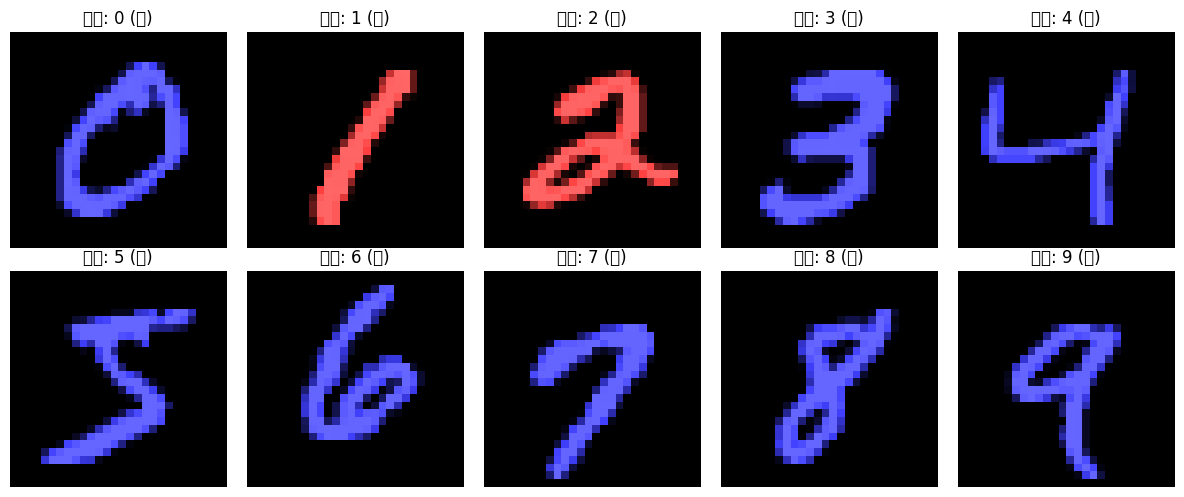

In [ ]:
# サンプル画像を表示
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    idx = np.where(y_digit == i)[0][0]
    ax = axes[i // 5, i % 5]
    img = x_colored[idx].transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    color = "赤" if y_color[idx] == 0 else "青"
    ax.set_title(f"数字: {i} ({color})")
    ax.axis('off')
plt.tight_layout()
plt.show()

### モデル定義: GRLを使った分岐型ネットワーク

ネットワーク構造:
1. **共有特徴抽出部**: CNNで画像から特徴を抽出
2. **分岐1（メインタスク）**: 数字分類（0-9の10クラス）
3. **分岐2（対立タスク）**: 色グループ分類（赤/青の2クラス） ← **GRLを通す**

In [ ]:
class ColorBiasRemovalCNN(nn.Module):
    """
    GRLを用いた色バイアス除去モデル
    """
    def __init__(self, lambda_grl=1.0):
        super(ColorBiasRemovalCNN, self).__init__()

        # 共有特徴抽出部
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 分岐1: 数字分類器 (メインタスク)
        self.digit_classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10クラス (0-9)
        )

        # 勾配反転層
        self.grl = GradientReversalLayer(lambda_=lambda_grl)

        # 分岐2: 色グループ分類器 (対立タスク)
        self.color_classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # 2クラス (赤/青)
        )

    def forward(self, x):
        # 共有特徴抽出
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)

        # 分岐1: 数字分類 (通常の経路)
        digit_output = self.digit_classifier(features)

        # 分岐2: 色分類 (GRLを通る経路)
        reversed_features = self.grl(features)
        color_output = self.color_classifier(reversed_features)

        return digit_output, color_output

### 比較用: GRLなしのモデル

GRLの効果を確認するため、GRLを使わない通常のマルチタスクモデルも定義する

In [ ]:
class NormalMultiTaskCNN(nn.Module):
    """
    通常のマルチタスクモデル(GRLなし)
    """
    def __init__(self):
        super(NormalMultiTaskCNN, self).__init__()

        # 共有特徴抽出部
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 分岐1: 数字分類器
        self.digit_classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

        # 分岐2: 色グループ分類器 (GRLなし)
        self.color_classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        digit_output = self.digit_classifier(features)
        color_output = self.color_classifier(features)
        return digit_output, color_output

### 学習関数の定義

両方のモデルで使える汎用的な学習関数を定義する

**損失関数の設定**:
- 数字分類: CrossEntropyLoss（最小化したい）
- 色分類: CrossEntropyLoss（GRLありの場合、共有部分では最大化される）

In [ ]:
def train_model(model, x_train, y_digit_train, y_color_train,
                epochs=10, batch_size=200, lr=0.001):
    """
    モデルを学習する
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    n = len(y_digit_train)
    history = {
        'digit_loss': [],
        'color_loss': [],
        'total_loss': []
    }

    model.train()
    for epoch in range(epochs):
        epoch_digit_loss = 0
        epoch_color_loss = 0
        epoch_total_loss = 0
        if hasattr(model, 'grl'):
            lambda_p = min(1.0, epoch / 5.0)
            model.grl.lambda_ = lambda_p

        # データをシャッフル
        idx = np.random.permutation(n)

        for i in range(0, n, batch_size):
            batch_idx = idx[i:min(i+batch_size, n)]

            x_batch = torch.FloatTensor(x_train[batch_idx]).to(device)
            y_digit_batch = torch.LongTensor(y_digit_train[batch_idx]).to(device)
            y_color_batch = torch.LongTensor(y_color_train[batch_idx]).to(device)

            # 順伝播
            digit_output, color_output = model(x_batch)

            # 損失計算
            digit_loss = criterion(digit_output, y_digit_batch)
            color_loss = criterion(color_output, y_color_batch)
            # 対立タスクの損失に重みをつける
            adversarial_weight = 2.0
            total_loss = digit_loss + adversarial_weight * color_loss

            # 逆伝播と最適化
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_digit_loss += digit_loss.item()
            epoch_color_loss += color_loss.item()
            epoch_total_loss += total_loss.item()

        # エポックごとの平均損失
        num_batches = (n + batch_size - 1) // batch_size
        history['digit_loss'].append(epoch_digit_loss / num_batches)
        history['color_loss'].append(epoch_color_loss / num_batches)
        history['total_loss'].append(epoch_total_loss / num_batches)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Digit Loss: {history['digit_loss'][-1]:.4f}, "
              f"Color Loss: {history['color_loss'][-1]:.4f}")

    return history

### 評価関数の定義

In [ ]:
def evaluate_model(model, x_test, y_digit_test, y_color_test):
    """
    モデルを評価する
    """
    model.eval()
    with torch.no_grad():
        x_test_tensor = torch.FloatTensor(x_test).to(device)
        digit_output, color_output = model(x_test_tensor)

        # 数字分類の精度
        digit_pred = digit_output.argmax(dim=1).cpu().numpy()
        digit_accuracy = (digit_pred == y_digit_test).mean()

        # 色分類の精度
        color_pred = color_output.argmax(dim=1).cpu().numpy()
        color_accuracy = (color_pred == y_color_test).mean()

    return digit_accuracy, color_accuracy

### データの分割

In [ ]:
# 学習用とテスト用に分割（80:20）
n_total = len(y_digit)
n_train = int(n_total * 0.8)

x_train = x_colored[:n_train]
y_digit_train = y_digit[:n_train]
y_color_train = y_color[:n_train]

x_test = x_colored[n_train:]
y_digit_test = y_digit[n_train:]
y_color_test = y_color[n_train:]

print(f"学習データ: {len(x_train)}")
print(f"テストデータ: {len(x_test)}")

学習データ: 48000
テストデータ: 12000


### 実験1: GRLありモデルの学習

**期待される結果**:
- 数字分類精度: 高い
- 色分類精度: **低い**（色情報が特徴から除去される）

In [ ]:
print("=" * 50)
print("GRLありモデルの学習")
print("=" * 50)

torch_fix_seed(42)
model_with_grl = ColorBiasRemovalCNN(lambda_grl=1.0)
history_with_grl = train_model(
    model_with_grl, x_train, y_digit_train, y_color_train,
    epochs=10, batch_size=200, lr=0.001
)

# 評価
digit_acc_grl, color_acc_grl = evaluate_model(
    model_with_grl, x_test, y_digit_test, y_color_test
)
print(f"\n【GRLあり - テスト結果】")
print(f"数字分類精度: {digit_acc_grl*100:.2f}%")
print(f"色分類精度: {color_acc_grl*100:.2f}% (低いほど良い、区別しないなら50がベスト)")

GRLありモデルの学習
Epoch 1/10 - Digit Loss: 0.3264, Color Loss: 0.1488
Epoch 2/10 - Digit Loss: 0.2748, Color Loss: 1.2770
Epoch 3/10 - Digit Loss: 0.0858, Color Loss: 0.6932
Epoch 4/10 - Digit Loss: 0.0694, Color Loss: 0.6931
Epoch 5/10 - Digit Loss: 0.0585, Color Loss: 0.6931
Epoch 6/10 - Digit Loss: 0.0515, Color Loss: 0.6932
Epoch 7/10 - Digit Loss: 0.0440, Color Loss: 0.6931
Epoch 8/10 - Digit Loss: 0.0381, Color Loss: 0.6931
Epoch 9/10 - Digit Loss: 0.0327, Color Loss: 0.6932
Epoch 10/10 - Digit Loss: 0.0304, Color Loss: 0.6932

【GRLあり - テスト結果】
数字分類精度: 98.62%
色分類精度: 50.21% (低いほど良い、区別しないなら50がベスト)


### 実験2: GRLなしモデルの学習

**期待される結果**:
- 数字分類精度: 高い
- 色分類精度: **高い**（色情報も学習してしまう）

In [ ]:
print("\n" + "=" * 50)
print("GRLなしモデルの学習")
print("=" * 50)

torch_fix_seed(42)
model_without_grl = NormalMultiTaskCNN()
history_without_grl = train_model(
    model_without_grl, x_train, y_digit_train, y_color_train,
    epochs=10, batch_size=200, lr=0.001
)

# 評価
digit_acc_normal, color_acc_normal = evaluate_model(
    model_without_grl, x_test, y_digit_test, y_color_test
)
print(f"\n【GRLなし - テスト結果】")
print(f"数字分類精度: {digit_acc_normal*100:.2f}%")
print(f"色分類精度: {color_acc_normal*100:.2f}%")


GRLなしモデルの学習
Epoch 1/10 - Digit Loss: 0.3908, Color Loss: 0.0135
Epoch 2/10 - Digit Loss: 0.0801, Color Loss: 0.0000
Epoch 3/10 - Digit Loss: 0.0536, Color Loss: 0.0000
Epoch 4/10 - Digit Loss: 0.0591, Color Loss: 0.1020
Epoch 5/10 - Digit Loss: 0.0465, Color Loss: 0.0000
Epoch 6/10 - Digit Loss: 0.0369, Color Loss: 0.0000
Epoch 7/10 - Digit Loss: 0.0293, Color Loss: 0.0000
Epoch 8/10 - Digit Loss: 0.0245, Color Loss: 0.0000
Epoch 9/10 - Digit Loss: 0.0204, Color Loss: 0.0000
Epoch 10/10 - Digit Loss: 0.0184, Color Loss: 0.0000

【GRLなし - テスト結果】
数字分類精度: 98.83%
色分類精度: 100.00%


### 結果の比較とグラフ化

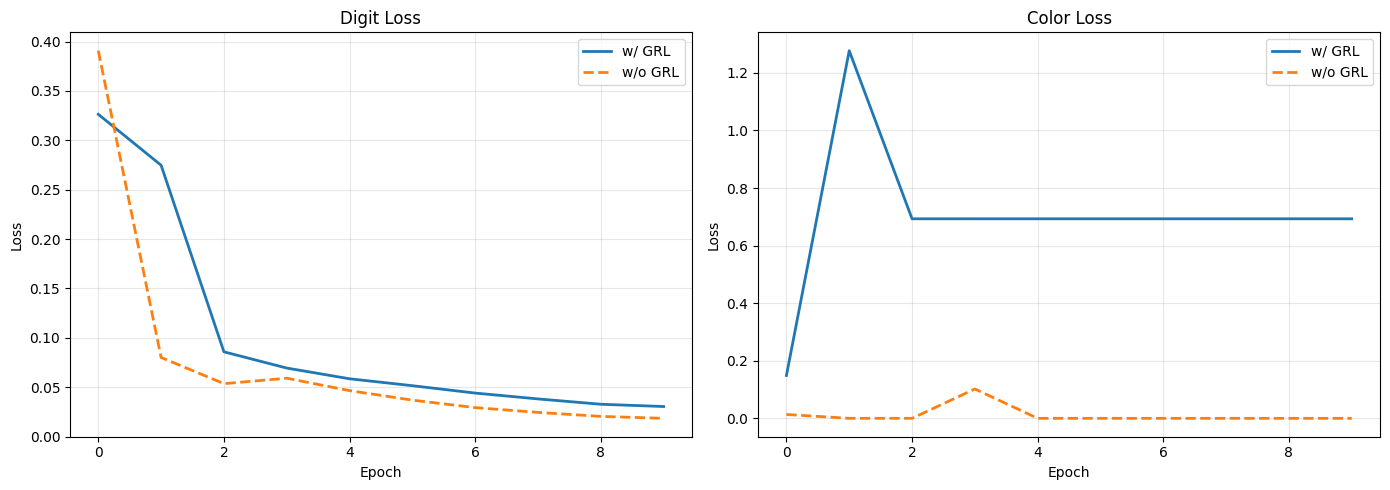

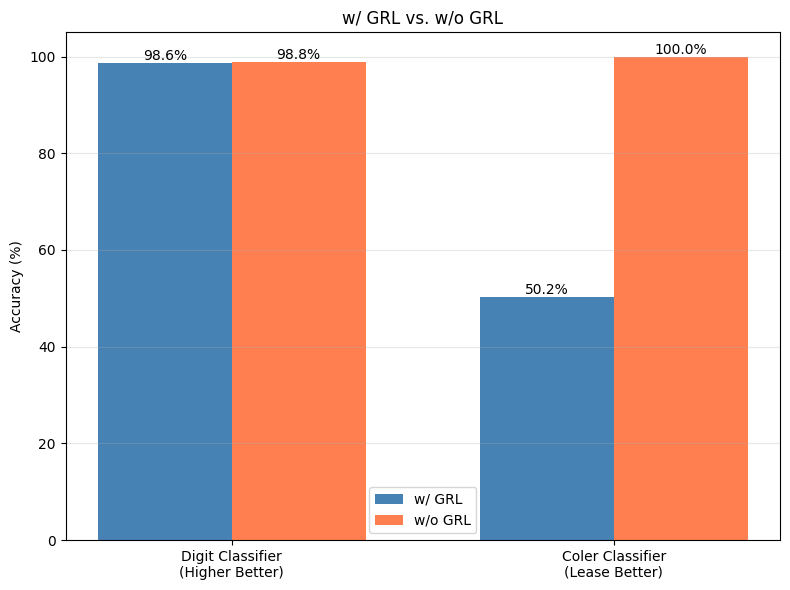

In [ ]:
# 学習曲線の比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 数字分類の損失
axes[0].plot(history_with_grl['digit_loss'], label='w/ GRL', linewidth=2)
axes[0].plot(history_without_grl['digit_loss'], label='w/o GRL', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Digit Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 色分類の損失
axes[1].plot(history_with_grl['color_loss'], label='w/ GRL', linewidth=2)
axes[1].plot(history_without_grl['color_loss'], label='w/o GRL', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Color Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 精度の比較
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
categories = ['Digit Classifier\n(Higher Better)', 'Coler Classifier\n(Lease Better)']
grl_scores = [digit_acc_grl * 100, color_acc_grl * 100]
normal_scores = [digit_acc_normal * 100, color_acc_normal * 100]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, grl_scores, width, label='w/ GRL', color='steelblue')
bars2 = ax.bar(x + width/2, normal_scores, width, label='w/o GRL', color='coral')

ax.set_ylabel('Accuracy (%)')
ax.set_title('w/ GRL vs. w/o GRL')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 数値をバーの上に表示
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 結果の解釈

**GRLありモデル**:
- 数字分類精度: 高い → メインタスクは正常に学習
- 色分類精度: 低い（ランダム予測の50%に近い） → 色情報が特徴から除去されている

**GRLなしモデル**:
- 数字分類精度: 高い
- 色分類精度: 高い → 色情報も学習してしまっている（バイアスが残る）

**結論**:
GRLを使うことで、メインタスク（数字分類）の性能を保ちながら、望ましくない情報（色バイアス）を特徴表現から除去できることが確認できた

## まとめ

### GRLの効果

1. **メインタスクの性能を維持しつつ、望ましくない情報を除去できる**
   - 数字分類の精度は高いまま
   - 色情報や偶数/奇数情報は予測できなくなる

2. **バイアスに頑健なモデルを構築できる**
   - データに含まれるバイアス（色、背景など）に惑わされない
   - 本質的な特徴（数字の形状）に基づいて判断

3. **公平性のある機械学習モデルを実現できる**
   - 性別、年齢、人種などの保護属性を予測できないようにする
   - タスク性能と公平性を両立

### GRLの仕組み（再確認）

- **順伝播**: 入力をそのまま通す
- **逆伝播**: 勾配を反転（符号を逆にする）
- **結果**:
  - 対立タスクの分類器は普通に学習（損失を最小化）
  - 共有特徴抽出部は対立タスクに対して混乱（損失を最大化）
  - メインタスクには有用だが、対立タスクには無用な特徴を学習

### 応用例

1. **ドメイン適応** (Domain Adaptation)
   - ソースドメインとターゲットドメインの違いを吸収
   - 例: 実写画像で学習したモデルをイラストに適用

2. **公平性の確保** (Fairness)
   - 保護属性（性別、年齢など）に依存しない予測
   - 例: 履歴書スクリーニングで性別バイアスを除去

3. **バイアス除去** (Debiasing)
   - データセットに含まれる偏りを軽減
   - 例: 色や背景などの無関係な情報を除去

### 注意点

- **λ（lambda）パラメータの調整が重要**
  - 大きすぎるとメインタスクの性能が低下
  - 小さすぎると対立タスクが十分に抑制されない
  
- **完全に情報を除去できるわけではない**
  - 対立タスクの精度を下げることはできるが、0%にはならない
  - より強力な除去には他の手法との組み合わせが必要な場合もある

# モデルのパラメタについて

## モデルパラメタの参照

モデルのパラメタを参照してみよう

- 先に述べた通り、model.parameters()はiterableなので、for文で順に表示させることができる
- 小さなネットワークであるが、大量のパラメタが存在することがわかる
- `Parameter containing:`で分けられたセクションそれぞれが、各層を意味し、複数のtensorがそれぞれのノードを意味する

次のような構造が1層分である
```
Parameter containing:
tensor([[パラメタ1],[パラメタ2],...,[パラメタn]],requires_grad=True)
```

このように、model.parameters()がmodelのパラメタを参照しておらず、modelのパラメタを持ったiteratorを返すためforを用いて表示させることができる
- 出力のために値を取り出したが、パラメタの書き換えは後で確認しよう


In [ ]:
for param in model.parameters():
    print(param)

NameError: name 'model' is not defined

また、dict型であるので、次のようにすると、どのような層とパラメタの種類があるかが確認できる

In [ ]:
print(model.state_dict().keys())

具体的に層の名称とweightやbiasを指定することで、該当するパラメタを抽出できる

In [ ]:
print(model.state_dict()['cn2.weight'])

さらにdict型を用いずとも、次のようにメンバ変数として参照することもできる
- weightをbiasに変えればバイアスも見ることができる

In [ ]:
print(model.cn2.weight)

さらに、optimizerはこれらのパラメタを全て受け取っていることから、optimizerからも確認可能である

In [ ]:
print(optimizer.param_groups)

optimizer.param_groupsは、辞書の配列であるため、次のようにしてアクセスすることもできる

In [ ]:
print(optimizer.param_groups[0]['lr'])

paramsをkeyとすればパラメタが取得でき、その最初の層のウェイトを参照するには次のようにすればよい

In [ ]:
print(optimizer.param_groups[0]['params'][0])

In [ ]:
print(model.state_dict()['cn2.weight'].grad)
print(model.cn2.weight.grad)
print(optimizer.param_groups[0]['params'][0].grad)

## モデルパラメタの書き換え

パラメタを書き換える場合、初期値を設定するように最初に変更する場合と、途中で変更したい場合がある

### 初期値の変更としての代入

まず、特に問題の少ない初期値を設定するための変更について述べる

次のような方法が存在する

- 値を代入
- nn.Parameter()を利用
- net.load_state_dict()を利用

#### 値を代入

パラメータの閲覧方法を利用し、そのまま代入するればよい

例えば、cn2の全チャネルのパラメタを書き換える場合は、
```
model.state_dict()['cn2.weight'][0] = torch.tensor([cn2に関する変更パラメタ])
```
とすればよい

cn2のチャネル1(最初のチャネル)を書き換ええる場合は、
```
model.cn2.weight[0] = torch.tensor([cn2のチャネル1に関する変更パラメタ])
```
とする

この全チャネルを書き換えるというのが、実は曲者であり、次のようにしても変更できない
- エラーも出力されない
```
model.state_dict()[cn2.weight'] = torch.tensor([cn2に関する変更パラメタ])
```
- この場合は、次のようにすると変更できる
```
model.state_dict()['cn2.weight'][:] = torch.tensor([cn2に関する変更パラメタ])
```

要するに全体を変更するのだ、と明示的に指定する必要がある


なお、次のようにしてもやはりダメ
- エラーが出力される
```
model.cn2.weight = torch.tensor([cn2に関する変更パラメタ])
```
- この場合、全体の変更であると指定しても解決しない
```
model.cn2.weight[:] =  torch.tensor([cn2に関する変更パラメタ])
```

#### nn.Parameter()を利用

パラメータの全チャネル一括変換する際に便利な方法で、お勧めする方法である

nnはtorch.nnというmoduleのこと
- このnnがもつnn.Parameter()メンバ関数は、nn.Linear()やnn.Conv2d()の内部で使用されているスーパークラスである
- パラメタ生成や操作の基本を司る

例えば、次のように指定する

In [ ]:
weight = nn.Parameter(torch.zeros(2,1,3,3))
print(weight)

これにより、先ほどより出ていた`Prameter containing:`は、このnn.Parameterにより与えられているパラメタのことを意味し、nn.Parameterにより与えられていたということがわかる

nn.Parameterでは、デフォルトで`requires_grad=True`と指定されていることから、そのまま代入しても問題ないことがわかる
- つまり、パラメタは、単なるtorch.tensorではなく、nn.Parameterにより定められた型(実際には`class 'torch.nn.parameter.Parameter'`)である

実際には、次のようにする
```
model.cn2.weight = nn.Parameter(torch.tensor([cn2に関する変更パラメタ]))
```

また、次のようにすると型が合わないため失敗する

```
model.state_dict()['cn2.weight'] = nn.Parameter(torch.tensor([cn2に関する変更パラメタ]))
```


#### net.load_state_dict()の利用

既に学んだが、Networkのパラメータを事前に外部に保存しておき、それをloadすることでパラメータを書き換えることができる
- まず保存する=`torch.save(model.state_dict(), 'ファイル名.pth')`
- 保存したパラメタを読み込む=`param = torch.load('ファイルのpath')`
- 読み込んだパラメタを実際にネットワークに適用する=`model.load_state_dict(param)`

さて、この読み込んだパラメタに修正を加えてネットワークに適用することができる

```
param = torch.load('ファイルのpath')
param2 = model.state_dict()
param2['cn2.weight'] = param['cn2.weight']
net.load_state_dict(param2)
```


### パラメタを途中で変更(.dataの利用)

モデルパラメタを途中で書き換えるには、`.data`を利用して代入するとよい

まず、なぜ途中で変更する場合は、先に述べた最初に変更する手法と違う方法になるのかが気になるであろうから、この点を説明する

```
model = Network()
optimizer = optim.SGD(model.parameters())
```
などとするが、このoptimizerにパラメタを渡すときに、modelのパラメタがoptimizerにコピーされるため、modelのパラメタを変更しても、optimizerのパラメタは更新されない
- つまり、初期値の変更で説明した方法では変更できない

そこで、専用の方法として、`.data`を利用する
- nn.Parameter()で定義されたTensor型dataを用いる手法で、nn.Parameter()内にあるtensor型データ要素のみを取得でき、またこれを変更できる

まず、この点を確認する
- 次のように型が異なる

In [ ]:
print(type(model.cn2.weight))
print(type(model.cn2.weight.data))

そこで、書き換えるには次のようにする
- modelに対する変更であるが、`.data`を利用することで、optimizerも変更される

```
model.cn2.weight.data = torch.tensor([cn2に関する変更パラメタ])
```
これで変更される

また、`optimizer.param_groups[0]['params'][0].data`としてもよい

また、具体的な値に変更するのではなく、何倍かに値をスケールさせるなどの演算を施したい場合は次のようにする
```
model.cn2.weight.data.add_(5.0)
model.cn2.weight.data.mul_(0.1)
```

代入と同様、`optimizer.param_groups[0]['params'][0].data`とすることもでき、optimizerで修正することも、部分的に修正することもできる

# PyTorch ver.2 からの新機能

PyTorch ver.2 より、新たにコンパイラ機能が搭載されている

これは、modelをコンパイルし、大きなモデルに対して、およそ5%から30%程度高速化し、VRAM使用量もVRAM使用率も5から10%弱程度であるが現象する機能である
- CUDA 11.6以降が必要
- このテキストではCUDAを含む、様々なバージョンの関係から率先して利用していないが、個人でテキストを試す場合はぜひこのコンパイラ機能を試してみるとよいだろう(試験においても合法とみなします)

特長として以下の点が挙げられる
- 精度が低下することはないため安心して利用できる
- 小さなモデルに対して、学習は速くならず、コンパイルオーバヘッドのためepochsが少ない場合は全体として遅くなる
- GPU使用率は僅かに低くなる傾向
- GPUだけでなくCPUも効率良く使える場合は特に高い効果が期待できる

コンパイルオプションが様々存在するが、基本的にはデフォルトで問題ない

## 使い方

シンプルで、次のようにmodelをコンパイルして再定義するだけである

```
Python
# model: torch.nn.Module
model = torch.compile(model)
```

これほどよい仕組みであれば、デフォルトでONにしてもよいが、現状では意図してコンパイルする必要がある

なお、必ずコンパイルが成功するということは保証されていないため、コンパイルできない場合も存在する
- ただし、公式発表において、多くのモデルがコンパイル可能であることが示されている

GitHubにあるレポジトリには、Toolsディレクトリの下にgpu.pyがある
- これを用いれば、pytorchやCUDAのバージョンの他、GPU情報などを調べることができる

なお、仕組みとしてはJITに近く、最初の1回だけでなく数回呼び出しが遅くなる
- また、forwardとbackwardで別々にコンパイルされるため、両方初回は遅くなる
- Google Colabにおいても利用可能であるが、途中でCellの実行を一度止めて再実行するとエラーとなり、ランタイムの再起動が必要となる場合がある


# 説明可能AI (Explainable AI)

AIは何が裏で行われているかよくわからないといわれる
- 感覚としては、ここまででDNNの気持ちはわかってもらえていると思う
- ただ、どうしてクラス分けができるのかはともかく、では、そのクラス分けに穴はないのか？例えば、特殊な画像を見せると容易に誤った結果を導いたりしないのか？を示すには証明が必要である
  - 実際にそういった画像は存在する
  - 例えば「かく乱画像」(adversarial image)と呼ばれる改変画像は認識精度を著しく損なうことができる
- ともかくも、AIは判断プロセスがブラックボックスであるとも言われる
- そこで、説明可能AIが提案されている
- GDPR（General Data Protection Regulation = EU一般データ保護規則）では、**消費者の説明を求める権利**が規定されており、このままではAIが利用できません

説明可能AIそのものの定義もかなりあいまい
- 学習過程について、根拠となったデータをきちんと示せば説明可能であるという考え方
  - 方法はブラックボックスだが、このデータのこの部分の特徴量がこの程度結果に関与していると示し、これを人間で確認できれば根拠を示したことになる？
- 解法そのものを証明できる形に変更する
  - 特徴量$x$に対してDNNによる非線形変換$f$があり、結果として$y$を得たとすると、$y=f(x)$という関係式が成り立つ
  - この意味での説明可能性は、$x=f^{-1}(y)$となる$f^{-1}$を導くことであるが、そもそも、次元圧縮(固有値0の固有ベクトルのようなもの)を行うため、逆行列や逆変換は存在しえず、完全に新規の手法

一般に前者の考え方が取られているが、そもそもそれは、**完全な説明可能ではない**
  - 材料を提供するだけで、判断は人間がしなさい、というシステム
  - 説明可能とするために、別のDNNを組み込む提案が殆どで、DNNのブラックボックスは何も説明していない
    - わけのわからないものが出した答えが正しいかわからないので、もう一度わけのわからないものを使って、その原因との関連を見てみましょうという考えはどうなのか？
    - こういう発想は実は多く、インターネットのサイト証明はCAという権威サーバにより証明されたサーバだから信じようという前提で、権威サーバが正しいことは誰も保証していない
    - 安全だとされる内容も、完全は存在せず、ブロックチェーンのビザンチン将軍問題(51%問題)、ハッシュの衝突問題、暗号の確率問題、サイドチャネルアタックなど


## SmoothGrad

わかりやすいメジャーな手法としてSmoothGradがある

その戦略はシンプルで、1枚の入力画像に複数のノイズを加え、それらから生成される複数の反応マップの平均を取ることで注目点を可視化する
- つまり、少しの値の変更が、あるクラスの識別スコアに大きく影響を与えるピクセルがあれば、このピクセルが識別に大きく寄与していると考えている
  - そのようなxの領域を可視化する
  - 当然ながら、ノイズを与えるためその標準偏差と平均化する際のサンプル数といったハイパーパラメータが存在する
  - ノイズは10%から20%程度、サンプル数は多いほどスムーズな結果の画像が得られる

<img src='http://class.west.sd.keio.ac.jp/dataai/text/smoothgrad.jpg' width=600>

## Grad-CAM

GradCAM(Gradient-weighted Class Activation Mapping)は、説明可能AIにおける基本となるアイデアを提供した

CNNを含むニューラルネットワークにおいて画像のどの部分に注目して判断がなされたかを可視化するための技術であり、どの部分に注目したかを示すため、判断材料の根拠の一つを提供する

### 以下の手順で求める

1. 最終出力の結果、maxにより推論の結果として得られたクラスのみを1とし、他を0にした状態で逆誤差伝播を行う
  - 従って、例えば犬と猫が両方映っている場合や、どちらともつきにくい画像である場合も、犬のみを1にする、もしくは猫のみを1にすることで、そのように判断した理由を推し量ることができる
1. 逆伝搬の計算がCNNの最終層に達したら各チャンネル毎に重みをGAP(Global Average Pooling)を用いて計算し、指定されたクラスにおける最終層の各チャンネルの重要度を決定
1. その重要度と各チャンネルの重みを掛けたのち、それらの総和を求める
1. その総和にReLUを施す
  - ReLUを施すのは、クラスに影響を与えてるのは正の勾配を持つ要素に限定されるため、影響を与えない負の値を無視するため
1. 得られた重みに従ってクラスの逆誤差を伝播させて画像を生成する(Guided Backpropagation)

<img src='http://class.west.sd.keio.ac.jp/dataai/text/gradcam.png' width=600>

### 以下の特徴を持つ

- 入力に続いてCNNが存在するネットワーク全てに対応し、CNNの後にどのようなネットワークが繋がっていてもよい(VQA、多クラス分類などでも利用可能)
- 入力画像とその時に推論結果とするクラスの両方の指定が必要
- ネットワークの構造を変えずに可視化できる
- 入力からCNNの層が連続し、その最終層の勾配から可視化する
- 細かい反応部分を求めることができないため、GuidedBackpropと掛け合わせてることで、より詳細な反応部分の可視化ができる
- VQAやResNetの可視化も行えるが、深い層から浅い層に行くにつれて出力サイズが大きく異なるときに精度が悪くなる

そもそも、基本発想は単純かつ、限定的で次の通り
- CNNに続くLinier層(全結合層)は画像の位置に関する情報が連した情報を完全に失ってしまい、また入力に近いところでは抽象度の低い認識しか行われないので、CNNの部分の最終そして全結合層の入力に当たる部分に双方を満たす情報があると考えている。


# GradCAMを試す

In [ ]:
import urllib
import pickle
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt
import seaborn as sns

## ImageNetの読み込み

ImageNetの学習済みモデルを用いる

ラベルとモデルをそれぞれ、labes, modelに読み込む

In [ ]:
labels = pickle.load(urllib.request.urlopen('http://class.west.sd.keio.ac.jp/dataai/data/imagenet1000_clsid_to_human.pkl'))
model = models.vgg19(pretrained=True)
model

## GradCAMの定義

GradCAMでは次の処理を行う
- 畳み込みの最終層でGlobalAveragePoolingを行う
- あるクラスにおける最終層の各チャネルの重要度を決定
- 重要度に応じて各チャンネルをかけて足し合わせる
- 足し合わせたものをReLU関数に通す

GradCamクラスは次の通り

- `__call__`で入力としての画像を与える
  - コードは複数の画像が与えられても動作するように`x.size(0)`の`for`ループがあるが、ここでは一つだけ与えている
  - 受け取った画像を最小を0、最大を1として正規化
  - 特徴量をfeatureに入れる
  - moduleのネットワーク階層を辿る
    - この部分はImageNetに特化している
    - moduleは、features, avgpool, classifierの3つで構成され、これらがこの順にそれぞれ1度だけ選択される
    - classifierになった時にその直前のfeaturesを保持する
    - featuresでは、勾配保存用メソッド`__save_grandient__`を呼び出すことで勾配を保存する
- 各チャネルの重要度を計算してweightへ代入
- 特徴量とweightを掛けて足し合わせる
- 結果のサイズを調整し、正規化、これを元の画像と重ね合わせる


In [ ]:
def z2onorm(d):
  # 単純に最小から最大を0から1で正規化
  d -= np.min(d)
  d /= np.max(d)
  return d

class GradCam:
  def __init__(self, model):
    self.model = model.eval()
    self.feature = None
    self.gradient = None
  def save_gradient(self, grad):
    self.gradient = grad
  def __call__(self, x):
    image_size = (x.size(-1), x.size(-2))
    feature_maps = []
    for i in range(x.size(0)):
      img = z2onorm(x[i].data.numpy()) # 正規化した入力(画像表示のとき元も出すため)
      feature = x[i].unsqueeze(0) # そのままの入力、こちらを利用
      for name, module in self.model.named_children():
        # モデルにあるノード名称を順次取得
        # 実際にはfeatures, avgpool, classifierとなる
        if name == 'classifier': # (4) 最後にclassifier
          print(feature.shape)
          feature = feature.view(feature.size(0), -1)
          # 途中で止めると途中の型変換が行われないのでfeatureの形を変換(表示しているので確認)
          print(feature.shape)
          # classifierであればfeatureを特徴量を取得
        feature = module(feature)
          # ここは3回評価されるが moduleなので、features, avgpool, classifierを順次計算する
          # (1)まずそのままの入力でfeatureだけ計算した出力を得る
          # (3)avgpoolで、featuresの演算を使い続きを計算
          # (4)classifierで、avgpoolの続きをさらに計算
        if name == 'features': # (2-1) 最初はfeature
          feature.register_hook(self.save_gradient)
          # 得た出力で逆伝搬計算する際にフックして勾配を取得するようにする
          self.feature = feature # (2-2) featureを記録
      classes = torch.sigmoid(feature) # sigmoidを求めているが、ここはなくてもよい
      one_hot, _ = classes.max(dim=-1) # ここでワンホット化
      self.model.zero_grad()
      one_hot.backward() # ワンホット化した内容で逆伝搬、上記のフックが働く
      weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
      # フックして取得した勾配から平均を求めることで重要度を計算
      mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
      # 重要度に記録しておいた特徴量を掛け合わせてReLUへ
      mask = cv2.resize(mask.data.cpu().numpy(), image_size)
      mask = z2onorm(mask)
      # 元の絵に重みを重畳して書き込む
      feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
      cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
      cam = z2onorm(cam)
      feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))

    feature_maps = torch.stack(feature_maps)
    # torch.Tensorをpyrhon listで結合したので、これをTensorにする
    return feature_maps

In [ ]:
import os
if not os.path.exists('testimg.jpg'):
  !wget "https://drive.google.com/uc?export=download&id=1nGpIBGphU3uxngGM5kclLj58tFo_ZNf1" -O testimg.jpg

transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
])

test_image = Image.open("./testimg.jpg")
test_image_tensor = (transform((test_image))).unsqueeze(dim=0)

image_size = test_image.size
print("image size: ", image_size)

plt.imshow(test_image)

In [ ]:
grad_cam = GradCam(model)

feature_image = grad_cam(test_image_tensor).squeeze(dim=0)
feature_image = transforms.ToPILImage()(feature_image)

pred_idx = model(test_image_tensor).max(1)[1]
print("pred: ", labels[int(pred_idx)])
plt.title("Grad-CAM feature image")
plt.imshow(feature_image.resize(image_size))

# 課題

入力画像を変えて、注目点の変化を確認しなさい


 # PyTorch Debugging Tips


このあたりまで学習を進めると、自身でデータを投入したり、モデルを修正、設計したりすることも容易であろう

そこで、デバッグに関する情報をまとめておく

## デバッグ初級編

- 文法上の問題は当然だが調べて取り除く

- 型の問題でエラーになる場合は、型や内容を調べて、とにかく合わせこめること

- エラーメッセージをとにかく確認する
  - 初心者はエラーメッセージの英語を読まずに、エラーが出たという事実だけで参ってしまうことが多い
  - エラーメッセージの確認は基本であり、これを追いかけること、少なくとも、エラーメッセージで検索するぐらいはやること

- 動作はするが、結果がおかしい場合は、動作を追いかけること
  - デバッグの仕方についてもある程度経験的に学べているとは思う尾が、その基本は「画面に表示してとにかく問題となる箇所を追いかける」ことである

- インストールバージョンの確認や更新を行うこと

- 自己構築の環境で問題が発生している場合は、Colabなどで動作確認するとよい
  - しばしば、GPUの違いやその対応状況によるトラブル、GPUメモリ搭載量によるトラブルなどが発生する

## デバッグ中級編

ある程度知識がひつよとなるのは、「動作するがうまくいかない」という場合である

次のようなパターンが存在する

- 仕様通りの設計はできているが、その設計自体の性能が不足し、ロスが下がらない、変な結果になるなど
  - モデルを修正することになるが、決して動作として間違えているわけではない
  - この点に気づかなければ、見当違いな修正を繰り返す可能性がある

- 型の合わせ込みで失敗しており、型はあっているが中身があっていないため正しく収束しない、なぜかしら出力がNaNになるなど

  - 各処理ステップの動作や出力結果を追いかけることになるが、大量のテンソルの中身を見ても何が正しいのかは判断が厳しいところ
  - バッチサイズを1にする、わかりやすい入力データを一時的に作るなどして、判断する
  
- 途中で固まる、ロスがとんでもない値で収束しない、メモリ不足になるなど
  - 設計そのものが間違えている可能性もあるが、Colabの場合仮想環境を完全にリセットして動作しなおすとうまくいく場合もあるので注意

## 身に着けたい対処方法(1. ネットワーク途中の結果を見たい)

ネットワークのforwardパスのある部分の結果を見たいことはしばしばあるであろう

- まずは、そのネットワーク定義の中にprintを埋め込めばよい

- 埋め込むのが嫌だ、もしくは、その部分の入力に狙った値を入れたい場合
  - ならば、次のコードが利用できる
  - これでNoNやInfといったイレギュラーな値が、望ましくない形で出ているかがわかる

参考コード

```
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cl1 = nn.Linear(25, 60)
        self.cl2 = nn.Linear(60, 16)
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.cl1(x))
        x = F.relu(self.cl2(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
def hook(model, input, output):
    if hasattr(model,'activations'):
        model.activations = torch.cat([model.activations,output.detach().unsqueeze(0)],dim=0)
    else:
        model.activations = output.detach().unsqueeze(0)
```

このコードを用いて、例えば、
```
model = MyModel()
model.fc2.register_forward_hook(hook)
x = torch.randn(1, 25)
output = model(x)
print(model.fc2.activations)
```
とすると結果を入手できる


- ネットワークのbackwordパスはPyTorchの自動微分で行われるので手が付けられない…
  - そんなことはありません
  - `torch.autograd.set_detect_anomaly(True)`と記述すれば、backwordパスで計算に失敗した層に関する詳細情報を得ることができる

身に着けたい対処方法(2. NaNを避けたい)

ネットワークがNaNを出力し、学習が進まないという事象が発生する場合がある
- 初期値や途中の計算値の組み合わせにより、巨大な値が算出され、問題はないが、NaNとなる可能性がある
- -infやinfといった値が生成され、NaNとなる場合などが含まれる

この場合は、`torch.clamp`を用いて、問題となっている出力変数の値の範囲を固定してしまうことである
- ある程度大きい値で制限して置けば、学習上問題とならない

```
torch.clamp(出力変数名, min=-65504.0, max=65504.0)
```

などとすればよい

# PyTorchの実行速度を向上させるTips

かなり学習も進んできた
- ここから先は、さらに実行時間が長く、学習が複雑かつ厄介な問題が続く
- そこで、備えとして実行速度を向上させるテクニックについて説明する
- 特にここにある事項について、必ず効果が得られるというわけではないため全てケアしているわけではないが、個人で実行する際には注意するとよい


## DataLoaderでWorkerを使用する

簡単に修正出来て、比較的効果の高い方法である

```
DataLoader(dataset, num_workers=8)
```
データローダにこのようにnum_workersを指定することで、競合問題が発生しているときも、これを回避し、遅延を隠ぺいできる可能性がある

これには、もう少し説明が必要であろう
- グローバルインタプリタロック(GIL)ロック問題というのがある
- Pythonなどプログラミング言語のインタプリタの実行単位であるスレッドによって保持される、スレッドセーフでないコード、つまり並列して実行すると支障が発生するコードを、他のスレッドと同時に共有して実行しないように排他的なロック機構を設ける仕組み
  - 電車のセマフォなどを用いて分散システムでよく説明されている

この例では、8つのバッチをそれぞれスレッドではなく、別のプロセスで処理するようになるため、GILロックを回避する

このワーカーの数については議論が必要であるが、おおよそ経験的に、
$$num_{worker} = 4 \times num_{GPU}$$
とするとよいであろう

なお、メモリ使用量が増えるため、大きなモデルを扱う時には注意すること

## メモリをピン止めしたままにする

メモリピンダウンは重要なテクニックであり、メモリピンダウンという用語と共にその意味を抑える必要がある

DNNの学習を進めていると、GPUメモリ不足によるエラーに遭遇した経験があるであろう
- ところが、実行しなおすと、とたんにエラーがなくなる
- どう考えても、今試しているモデルがメモリを大量に利用するとは思えない

といった疑問を抱いているのではないだろうか

このような問題を引き起こしているのが、メモリピンダウン(メモリのピン止め)であり、メモリをあらかじめ作業の割り当て場所として確保、予約していることにより発生している

なお、普通のPCのメモリにもピンダウンは存在し、ピン止めすると、そのメモリはディスクにスワップされなくなる
- 後で使うデータがわかっている場合は、その格納領域をピンダウンすればよい
- さらに速いキャッシュの中でピンダウンすることもある
- ピンダウンは高速化手法として有効だが、メモリ利用効率が下がるというデメリットがある

これを解消しようとして、ピンを外す、つまりメモリを開放することができる
- ただし、開放するということは、実行速度を低下させることになる
- なにかしらネットからコードをとってきて試してみるという場合、中にメモリを解放するコードが入っている場合は、実行速度に注意する必要がある
- `torch.cuda.empty_cache()`というコードには注意すること

DataLoaderは、メモリピンダウンを使うことで、取得したデータのTensorを自動的にピン止めされたメモリに置き、CUDA対応GPUへのデータ転送を高速化している
-  明示的に指定するには、`Dataloader(dataset, pin_memory=True)`とする

torch.cuda.empty_cache()をむやみに呼び出してはいけない

## CPUとGPU間の無駄なデータ転送を避ける

GPUはCPUに比較して何十倍も高速に計算できる能力を持っている
- 一方で、CPUとGPUの間でデータをやり取りする必要があるため、このデータ転送に係る時間がオーバヘッドとなる
- つまり、そのオーバヘッドに見合うだけの速度向上が見込めればGPUを使う意味があるということ
- 一般的には、データ転送よりも計算のコストが大きいため、GPUを使うと得をするが、データ転送をなめてはいけない

メモリコピーは大きなオーバヘッドを伴うことを知っておくこと
- Pythonの変数間代入におけるエイリアシングなど、既に学んだ通り、メモリコピーはとにかくコストのかかる処理である

Pytorchにおいては、`.cpu()`, `.item()`, `.numpy()`, `.nonzero()`, `.tolist()`といったコマンド(メソッド)を利用する際には、その必要性を十分に吟味すること
- これらの呼び出しは、毎回GPUからCPUにデータを転送し、特に小さなデータを細かく転送するとパフォーマンスを大きく低下させる

代わりに `.detach()`, `.from_numpy()`, `.as_tensor()`を使うこと
- `detach`はGPUに転送せず、その変数にアタッチされている計算グラフ(Pytorhが逆伝搬のために記録している計算履歴情報)を削除する

さらに、データ転送が重なる場合は、`tensor.to(non_blocking=True)`を使用するとよい


## PyTorch JITによるポイントワイズ(エレメントワイズ)演算のカーネル融合

コードに対して注釈を与えるように最適化コードを埋め込む必要があるが、強力な方法である

PyTorch JITを用いて、隣接するポイントワイズ演算を自動的に1つのカーネルに融合することでメモリの読み書きを節約することができる
- 例えば、gelu関数は5つのカーネルを1つに融合することで、100万個のベクトルに対して4倍高速化できるとされている

以下の例を挙げておくので、各自で調べるとよい
```
@torch.jit.script # JIT decorator
def fused_gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / 1.41421))
```

## バッチサイズは2の累乗か8の倍数

Nvidia GPUのテンソルコアは、行列の次元が2の累乗のとき行列乗算性能を発揮する構造となっている

## データ転送とカーネル実行をオーバーラップさせる

適用可能な場合は`tensor.to(non_blocking=True)`を使用する
- データ転送と実行をオーバーラップさせ、実行時間を短縮できる
  - non_blocking=Trueにより非同期のデータ転送を可能にして実行時間を短縮させることができる
- なお、データローダなどはCUDAのコアレスアクセスを率先して使うように最適化されているため、これによる効果は限定的かもしれない


## GPUに直接テンソルを構築

`t = tensor.rand(2,2).cuda()`

この記述では、まずCPUでテンソルを作成した後GPUに転送する、という処理が行なわれる
- つまり、オーバヘッドが大きい

代りに次のようにする

`t = tensor.rand(2,2, device=torch.device('cuda:0'))`

直接GPU上にテンソルを生成することができる
- その他、`torch.empty()`, `torch.zeros()`, `torch.full()`, `torch.ones()`, `torch.eye(`), `torch.randint()`, `torch.rand()`, torch.randn()`などでも利用できる

その他の場合でも、例えば、ループの中で何度もテンソルを初期化するなどする場合、毎回CPUからGPUに転送するのは無駄である
- ループに入る前に最初にCPUで作成して、GPUに転送した後、これをGPU内で保持しておき、ループの中では、GPU内で保持した値をGPU内でcopyして利用するといった工夫も有効であろう

## 16ビット精度の利用

このテキストでも、画像生成ネットワーク、例えばtext-to-imageなどでは率先して使っているが、単精度演算にするとGPUの計算性能を飛躍的に拡大できる

メリットは次の通り

- メモリ使用量が半分になるためメモリを有効に利用できる
  - つまりバッチサイズを2倍にして、トレーニング時間を半分にすることができる
  - 一部の古いGPU、例えばV100や2080Tiなどは16ビット計算に最適化されているため、3倍から8倍といったスループット向上が期待できる

これには、Tensorの宣言を16ビットにするなど、様々工夫が必要である

一方で、これを簡単化する方法もいくつか存在する
- Pytorch Lightingでは、`Trainer(precision=16)`とする
- `from fp16util import network_to_half`を利用して、例えば`net = network_to_half(net)`とする

なお、GPUのアーキテクチャによって、得意な精度が異なっている
- 他も利用できるが、エミュレーションが入るため実行速度は落ちる
  - Turingだと、INT1,4,8/FP16
  - Ampereだと、INT1,4,8/FP16,64/TF32/bfloat16
  - Hopperだと、INT8/FP8,16,64/bfloat16/TF32

但し、精度を16にしたからと言って、必ず良くなるとは限らない
- アルゴリズム、データ、問題に依存し精度に影響する可能性がある
- モデルの精度性能と速度性能のスイートスポットを見つける必要がある

Pytorchの自動混合精度(AMP)パッケージを使えば、PyTorchでの混合精度の利用が簡単になる

## オプティマイザが重みを更新する前に勾配をNoneに設定

`model.zero_grad()`または`optimizer.zero_grad()`として勾配をゼロに設定する
- どちらも同じ意味なので、どちらか実行すればよい
- これですべてのパラメータに対して memsetが実行され、読み取りと書き込み操作によって勾配が更新される
- gradientsをNoneに設定すると、memsetは実行されず、書き込み操作のみでgradientsが更新されるため、gradientsをNoneに設定する方が高速

```
model.zero_grad(set_to_none=True)
# or
optimizer.zero_grad(set_to_none=True)
```

## 勾配の蓄積

この方法はGPUサイズが小さいときに実践的な方法である

- 大きなバッチサイズを模倣するため1つおきのバッチで重みを更新する
- より多くのデータサンプルからの勾配を求めるため汎化性能の向上が見込める

```
for i, (features, target) in enumerate(dataloader):
    # Forward pass
    output = model(features)
    loss = criterion(output, target)
    # Backward pass
    loss.backward()
    # Only update weights every other 2 iterations
    # Effective batch size is doubled
    if (i+1) % 2 == 0 or (i+1) == len(dataloader):
        # Update weights
        optimizer.step()
        # Reset the gradients to None
        optimizer.zero_grad(set_to_none=True)
```

## 推論・検証では勾配計算をオフにする

推論と検証のステップでモデル出力を計算する場合は勾配計算が不要である
- PyTorchはrequests_grad=Trueとすると、よりサイズの小さい中間メモリバッファを使用して高速に演算しようとする
- 勾配に関わる演算が必要ないことが分かっている場合は、勾配計算を無効にすることで、追加リソースの使用を避けることができる

```
# torch.no_grad() as a context manager:
    with torch.no_grad():
    output = model(input)
# torch.no_grad() as a function decorator:
@torch.no_grad()
def validation(model, input):
    output = model(input)
return output
```

## torch.backends.cudnn.benchmark=Trueの設定

学習ループの前に `torch.backends.cudnn.benchmark = True` を設定すると計算を高速化できる

異なるカーネルサイズの畳み込み演算では、cuDNNアルゴリズムの性能が変化しやすく、これを自動的にチューニングする
- 入力サイズが頻繁に変化しない場合はこの設定をオンにするとよい
- 入力サイズが頻繁に変化する場合は、自動チューナーが頻繁にベンチマークを実行するため、パフォーマンスが低下する

この手法により、1.5倍程度高速化できる

## 4D NCHWテンソルにはchannels_lastメモリ形式を使用

4D NCHWをNHWC形式として再編成し、channels_lastメモリフォーマットを使用すると、メモリ内で最も密度の高いフォーマットとなり、2割程度高速時実行できる
- 画像限定の方法
- 4次元NCHWテンソルは、メモリ上で各チャンネル（赤/緑/青）ごとにクラスタリングされる
- 従って、`x = x.to(memory_format=torch.channels_last)`と変換すると、NHWC（channels_lastフォーマット）として再編成され、RGBレイヤーの各ピクセルが距離的に近くなる


## バッチ正規化直前の畳み込み層のバイアスはオフにする

バイアスの効果はバッチ正規化の平均減算で打ち消されるため、意味がない
- ならば、オフにしてしまっても構わない
- モデルパラメータ、実行時間、メモリを節約できる

```
nn.Conv2d(..., bias=False)
```
とする

## DistributedDataParallelを使用する

PyTorchには複数のGPUで学習するためのモデルが2つある
- DataParallel(DP)は、複数のGPUに渡ってバッチを分割する
  - モデルを各GPUにコピーする必要があり、GPU0で勾配を計算した後、他のGPUと同期する必要がある事を意味する
  - GPU内部でのデータ転送を伴うため、CPU-GPU間ほどひどくはないが、回数が重なるとオーバヘッドが大きくなる
- DistributedDataParallel (DDP)は、各GPU上にモデルを縦割り分割したコピーを作成し、各GPUでデータの一部のみ利用するように分割される
- この場合、各バッチにおいて、GPU間のデータ転送が一度しか発生しないことを意味する

DistibutedDataParallelを利用し、バッチサイズを大きく設定するとよい

## コードのプロファイリング

どの関数、どの場所でどの程度時間がかかり、どの程度呼び出されているか、これらの情報を入手することなく、実行速度を削減することはほぼ無理

このような情報を入手する方法について簡単に紹介しておく

- torch.profilerを使う
```
with torch.profiler.profile(
    schedule=torch.profiler.schedule(
        wait=2,
        warmup=2,
        active=6,
        repeat=1),
    on_trace_ready=tensorboard_trace_handler,
    with_trace=True
) as profiler:
```
などと宣言しておき、
```
optimizer.step()
profiler.step()
```
といった具合に、optimierでパラメタ更新した後に、プロファイラ情報も保存するようにする  
これで、json形式でプロファイラ情報が書き込まれる
  - これを見たい場合は、tensorboardを使うのが便利
  - `pip install torch_tb_profiler`として、`tensorboard --logdir logdir`としてみると様々な情報を取得できる

- Torch Lightingでお気楽に取得する  
`Trainer(profile=True)`  
とするか、アドバンストプロファイラを用いて
```
profiler = AdvancedProfiler()
trainer = Trainer(profiler=profiler) です．
これは、非常に詳細な情報を得ることができます。
```
とすることで、テキスト情報として結果を取得できる
  - シンプルでさっと済ますにはよい


# エポックにより学習率を自動的に変更

PyTorchには、エポックに応じて学習率を変更するSchedulerがあり、次のような種類がある

- lr_scheduler.LambdaLR
- lr_scheduler.MultiplicativeLR
- lr_scheduler.StepLR
- lr_scheduler.MultiStepLR
- lr_scheduler.ConstantLR
- lr_scheduler.LinearLR
- lr_scheduler.ExponentialLR
- lr_scheduler.CosineAnnealingLR
- lr_scheduler.ChainedScheduler
- lr_scheduler.SequentialLR
- lr_scheduler.ReduceLROnPlateau
- lr_scheduler.CyclicLR
- lr_scheduler.OneCycleLR
- lr_scheduler.CosineAnnealingWarmRestarts

スケジューラーを使うには、モデルとオプティマイザーが必要なため、はじめにモデルを準備し、学習率を表示する関数を定義して動作を確認する





In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

model = nn.Sequential(nn.Linear(1, 1), nn.Linear(1, 1))

# 学習率表示用
def lr_plot(scheduler):
    lrs = []
    for i in range(100):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

    plt.plot(lrs)

## lr_scheduler.MultiStepLR

マイルストーンを設定し、エポック数がマイルストーンに達すれば学習率が減衰する

milestonesにマイルストーンとなるエポック数を指定、gammaにマイルストーン時に乗算する値を指定する

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
lr_plot(scheduler)

## lr_scheduler.LinearLR

線形に学習率を変更するスケジューラー

start_factorに1エポック目の学習率を、end_factorに最終的な学習率を、total_itersに最終学習率に何エポックで到達させるかを指定する

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=50)
lr_plot(scheduler)

## lr_scheduler.ExponentialLR

エポック毎にガンマの値を乗算していくスケジューラー

gammaにエポック毎に乗算する値を指定する


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
lr_plot(scheduler)

# 課題1(ランタイムパラメタ変更)

学習途中でパラメタを強制変更することで、どのような変化が起きるかを確認する

そこで、
- 普通に学習させる
- パラメタを強制的に変更して学習させる

これら2つの場合を比較し、
- パラメタを強制的に変更しても学習することができるか？
- 普通に学習させた場合と、学習の速度や精度についてどのような変化があるか？

を確認する

課題は、上記2点についての考察も含めること

用いるプログラムは、このテキストの「参考プログラム」の一番最初に記述した無加工のプログラムで、モデル定義クラスの部分は次のように修正しなさい

```
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(50 * 8 * 8, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
```

このモデルの学習において、fc2を強制的にweightを全て0.5にしなさい

すなわち、
```
        xの生成
        model.fc2.weight.data = 0.5だけで構成されたtorch.tensorの配列
        output = model(x)
        loss = criterion(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```
等とする

# 課題2(複数目的による学習)

## 課題2-1
次のコードは、Processing( https://processing.org )を用いて丸:0、四角:1、三角:2の3種類の画像を32x32の中にランダムな場所に書き出し、その画像の種類の番号(0-2)、中心座標、大きさといった画像パラメタをcsvファイルとして保存するプログラムである

各自Processingをインストールしてこのプログラムを実行し、生成されたデータセット(imgフォルダにある2000枚の画像データおよび、各画像データのパラメタ集であるdata.csv)を読み込み、画像の種類および画像の中心をそれぞれ求める学習モデルを作成しなさい

また、次の事項を守ること

- モデルは分岐型としたうえで自由に設計してよい
- 25%を検証データとしなさい
- 検証の際、ラベルの正答率、座標の平均MSEをそれぞれ評価しなさい
- 精度は問わないが、極端に悪い場合は採点で考慮される

```
int xsize = 32;
int ysize = 32;
int wmax = 16;
int wmin = 8;
int numofshape = 2000;

String[] savestr = new String[numofshape];

void setup(){
  size(32, 32);
  ellipseMode(CENTER);
  rectMode(CENTER);
  noLoop();
}

void draw(){
  for(int i = 0; i < numofshape; i++){
    background(255);
    drawshape(i);
  }
  saveStrings("data/data.csv", savestr);
}

void drawshape(int num){
  int x = int(random(xsize-wmin*2))+wmin;
  int y = int(random(ysize-wmin*2))+wmin;
  int w = int(random(wmax-wmin))+wmin;
  int t = int(random(3));
  if(t == 0){
    circle(x, y, w);
  }else if(t == 1){
    rect(x, y, w, w);
  }else if(t == 2){
    triangle(x, y-w/2, x-w/2, y+w/2, x+w/2, y+w/2);
  }
  save("data/img/img"+num+".jpg");
  savestr[num] = str(t)+","+str(x)+","+str(y)+","+str(w);
}
```

## 課題2-2

課題2-1について、画像の幅も推定し、同様に精度を求めなさい

また、画像上に、
- 丸であれば青
- 四角であれば赤
- 三角であれば黄

の四角(bounding box)を描画して表示させなさい
- なお、数枚のサンプルがあればよい
